In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
from collections import deque

import os
import habitat
import math

os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import skimage
import skfmm

import gym
import logging
from arguments import get_args
from pointnav_env import Pointnav_Env
from utils.storage import GlobalRolloutStorage, FIFOMemory
from utils.optimization import get_optimizer
from model import RL_Policy, Local_IL_Policy, Neural_SLAM_Module
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.datasets.pointnav.pointnav_dataset import PointNavDatasetV1
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from util import AgentPositionSensor
from utils.fmm_planner import FMMPlanner

from ppo import PPO
import utils.pose as pu

import sys
import matplotlib

if sys.platform == 'darwin':
    matplotlib.use("tkagg")
import matplotlib.pyplot as plt

import random
from typing import Type, Union
from habitat import Config, Env, RLEnv, make_dataset
from vectorenv import VectorEnv, get_local_map_boundaries
from habitat_baselines.common.environments import get_env_class
from matplotlib.patches import Circle
from arguments import multiple_config, init_config
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
argumnts = ''
args = get_args(argumnts)
args.num_processes = 2

np.random.seed(args.seed)
torch.manual_seed(args.seed)

if args.cuda:
    torch.cuda.manual_seed(args.seed)
config = init_config()

Auto GPU config:
Number of processes: 15
Number of processes on GPU 0: 15
Number of processes per GPU: 0


In [3]:
log_dir = "{}models/{}/".format(args.dump_location, args.exp_name)
dump_dir = "{}dump/{}/".format(args.dump_location, args.exp_name)
if not os.path.exists(log_dir):
        os.makedirs(log_dir)
if not os.path.exists("{}/images/".format(dump_dir)):
    os.makedirs("{}/images/".format(dump_dir))

In [4]:
def init_map_and_pose():
    full_map.fill_(0.)
    full_pose.fill_(0.)
    full_pose[:, :2] = args.map_size_cm / 100.0 / 2.0

    locs = full_pose.cpu().numpy()
    planner_pose_inputs[:, :3] = locs
    for e in range(num_scenes):
        r, c = locs[e, 1], locs[e, 0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        full_map[e, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.0

        lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                          (local_w, local_h),
                                          (full_w, full_h), args)

        planner_pose_inputs[e, 3:] = lmb[e]
        origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                      lmb[e][0] * args.map_resolution / 100.0, 0.]

    for e in range(num_scenes):
        local_map[e] = full_map[e, :, lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
        local_pose[e] = full_pose[e] - \
                        torch.from_numpy(origins[e]).to(device).float()

# One env

In [5]:
def draw():
    circ = Circle(((one_env.trux+12)/args.map_size_cm*48000,(one_env.truy+12)/args.map_size_cm*48000),3,color='white')
    circ2 = Circle(((one_env.trux+12)/args.map_size_cm*48000,(one_env.truy+12)/args.map_size_cm*48000),3,color='white')
    circ3 = Circle(((one_env.goalx+12)/args.map_size_cm*48000,(one_env.goaly+12)/args.map_size_cm*48000),3,color='red')
    circ4 = Circle(((one_env.goalx+12)/args.map_size_cm*48000,(one_env.goaly+12)/args.map_size_cm*48000),3,color='red')
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(231)
    ax2 = f.add_subplot(232)
    ax3 = f.add_subplot(233)
    ax.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')
    ax.add_patch(circ)
    ax2.add_patch(circ2)
    ax.add_patch(circ3)
    ax2.add_patch(circ4)
    ax.imshow(one_env.map)
    ax.set_title('map')
    ax2.imshow(one_env.explored_map)
    ax2.set_title('explored_map ')
    ax3.imshow(np.transpose(obs['rgb'], (1,2,0)))

In [6]:
num_scenes = args.num_processes
num_episodes = int(args.num_episodes)
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
policy_loss = 0

best_cost = 100000
costs = deque(maxlen=1000)
exp_costs = deque(maxlen=1000)
pose_costs = deque(maxlen=1000)

g_masks = torch.ones(num_scenes).float().to(device)
l_masks = torch.zeros(num_scenes).float().to(device)

best_local_loss = np.inf
best_g_reward = -np.inf

if args.eval:
    traj_lengths = args.max_episode_length // args.num_local_steps
    explored_area_log = np.zeros((num_scenes, num_episodes, traj_lengths))
    explored_ratio_log = np.zeros((num_scenes, num_episodes, traj_lengths))

g_episode_rewards = deque(maxlen=1000)

l_action_losses = deque(maxlen=1000)

g_value_losses = deque(maxlen=1000)
g_action_losses = deque(maxlen=1000)
g_dist_entropies = deque(maxlen=1000)

per_step_g_rewards = deque(maxlen=1000)

g_process_rewards = np.zeros((num_scenes))

In [7]:
def draw_full():
    f = plt.figure(figsize=(15,10))
    circ = Circle((local_pose[0][0]/args.map_size_cm*48000,local_pose[0][1]/args.map_size_cm*48000),3,color='red')
    
    circ2 = Circle((one_env.start_240_240[0],one_env.start_240_240[1]),1,color='red')
    circ5 = Circle((one_env.goal_240_240[0],one_env.goal_240_240[1]),3,color='white')
    circ6 = Circle((one_env.stg[0],one_env.stg[1]),1,color='green')
    
    circ3 = Circle((trux[0]-120-(lmb[0,2]-120),truy[0]-120-(lmb[0,0]-120)),3,color='red')
    circ4 = Circle((goalx[0]-120-(lmb[0,2]-120),goaly[0]-120-(lmb[0,0]-120)),3,color='white')
    circ7 = Circle((one_env.stg[0],one_env.stg[1]),3,color='green')
    
    circ8 = Circle((trux[0],truy[0]),3,color='red')
    circ9 = Circle((goalx[0],goaly[0]),3,color='white')
    circ111 = Circle((one_env.local_goal_x_y[0],one_env.local_goal_x_y[1]),3,color='green')
    circ22 = Circle((one_env.goal_to_planer[0]-one_env.local_map_frame[2]+1,one_env.goal_to_planer[1]-one_env.local_map_frame[0]+1),3,color='white')
    circ33 = Circle((one_env.start_240_240[0]-one_env.local_map_frame[2]+1,one_env.start_240_240[1]-one_env.local_map_frame[0]+1),3,color='red')
    circ10 = Circle((trux[0],truy[0]),3,color='red')
    circ11 = Circle((goalx[0],goaly[0]),3,color='green')

    ax = f.add_subplot(231)
    ax2 = f.add_subplot(232)
    ax3 = f.add_subplot(233)
    ax4 = f.add_subplot(234)
    ax5 = f.add_subplot(235)
    ax6 = f.add_subplot(236)
    ax.imshow(global_input[0,0,:,:].cpu())
    ax.add_patch(circ)
    ax2.imshow(one_env.map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]])
    ax2.add_patch(circ2)
    ax2.add_patch(circ5)
    ax2.add_patch(circ6)
    ax3.imshow(obs_rgb.cpu()[0][1])
    ax4.imshow(one_env.explored_map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]])
    ax4.add_patch(circ3)
    ax4.add_patch(circ4)
    ax4.add_patch(circ7)
    ax5.imshow(one_env.traversible)
    ax5.add_patch(circ111)
    ax5.add_patch(circ22)
    ax5.add_patch(circ33)
    #ax6.imshow(one_env.explorable_map)
    #ax6.add_patch(circ10)
    #ax6.add_patch(circ11)
    
    f.canvas.draw()
    
    f.savefig('./img/{}.png'.format(10000+step))
    plt.close()

In [8]:
env_class = get_env_class("Pointnav_Env")
dataset = make_dataset(config.DATASET.TYPE, config=config.DATASET)
one_env = env_class(argss=args, rank=range(1),
                          config_env=config, dataset=dataset)

2020-07-14 13:35:38,763 Initializing dataset PointNav-v1
Initializing dataset PointNav-v1
2020-07-14 13:36:44,885 initializing sim Sim-v0
initializing sim Sim-v0
2020-07-14 13:36:50,845 Initializing task Nav-v0
Initializing task Nav-v0


In [9]:
args.num_processes = 1
num_scenes = 1
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
l_observation_space = gym.spaces.Box(0, 255,
                                     (3,
                                      args.frame_width,
                                      args.frame_width), dtype='uint8')
l_hidden_size = args.local_hidden_size
# slam
nslam_module = Neural_SLAM_Module(args).to(device)
# Local policy
l_policy = Local_IL_Policy(l_observation_space.shape, one_env.action_space.n,
                           recurrent=args.use_recurrent_local,
                           hidden_size=l_hidden_size,
                           deterministic=args.use_deterministic_local).to(device)
#state_dict = torch.load('./model_best.slam',
#                            map_location=lambda storage, loc: storage)
#nslam_module.load_state_dict(state_dict)
#state_dict = torch.load('./model_best.local',
#                            map_location=lambda storage, loc: storage)
#l_policy.load_state_dict(state_dict)
local_optimizer = get_optimizer(l_policy.parameters(),
                                args.local_optimizer)
slam_optimizer = get_optimizer(nslam_module.parameters(),
                               args.slam_optimizer)
slam_memory = FIFOMemory(args.slam_memory_size)

In [10]:
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
map_size = args.map_size_cm // args.map_resolution
full_w, full_h = map_size, map_size
local_w, local_h = int(full_w / args.global_downscaling), \
                   int(full_h / args.global_downscaling)
g_masks = torch.ones(num_scenes).float().to(device)
l_masks = torch.zeros(num_scenes).float().to(device)
full_map = torch.zeros(1, 4, full_w, full_h).float().to(device)
local_map = torch.zeros(1, 4, local_w, local_h).float().to(device)
full_pose = torch.zeros(1, 3).float().to(device)
local_pose = torch.zeros(1, 3).float().to(device)
global_input = torch.zeros(1, 8, local_w, local_h)
global_orientation = torch.zeros(1, 1).long()
planner_pose_inputs = np.zeros((1, 7))
lmb = np.zeros((1, 4)).astype(int)
origins = np.zeros((1, 3))

In [ ]:
!rm /root/ANM_CLEAN/img/*
obs, info = one_env.reset()
step = 0
init_map_and_pose()

#follower = ShortestPathFollower(one_env.habitat_env.sim, 0.36, False)

poses = torch.from_numpy(np.asarray(
    [info['sensor_pose']])).float().to(device)
obs_rgb = torch.from_numpy(np.expand_dims(obs['rgb'], axis=0)).float().to(device)

_, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
    nslam_module(obs_rgb, obs_rgb, poses, local_map[:, 0, :, :],
                 local_map[:, 1, :, :], local_pose)

locs = local_pose.cpu().numpy()
global_input = torch.zeros(1, 8, local_w, local_h)
global_orientation = torch.zeros(1, 1).long()
r, c = locs[0, 1], locs[0, 0]
loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                    int(c * 100.0 / args.map_resolution)]
local_map[0, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.
global_orientation[0] = int((locs[0, 2] + 180.0) / 5.)
global_input[:, 0:4, :, :] = local_map.detach()
global_input[:, 4:, :, :] = nn.MaxPool2d(args.global_downscaling)(full_map)
goalx,goaly = ((one_env.goalx)+12)/args.map_size_cm*48000, ((one_env.goaly)+12)/args.map_size_cm*48000
global_goals = [[int(goalx),int(goaly)]] 

planner_inputs = [{} for e in range(num_scenes)]
for e, p_input in enumerate(planner_inputs):
    p_input['goal'] = global_goals[e]
    p_input['map_pred'] = global_input[e, 0, :, :].detach().cpu().numpy()
    p_input['exp_pred'] = global_input[e, 1, :, :].detach().cpu().numpy()
    p_input['pose_pred'] = planner_pose_inputs[e]

# Output stores local goals as well as the the ground-truth action
#output = envs.get_short_term_goal(planner_inputs)

last_obs = obs_rgb.detach()
local_rec_states = torch.zeros(1, l_hidden_size).to(device)

rm: cannot remove '/root/ANM_CLEAN/img/*': No such file or directory


In [24]:
obs, info = one_env.reset()
step = 0
init_map_and_pose()

2020-07-14 13:31:27,797 Computing map for /data/scene_datasets/gibson/Adrian.glb
Computing map for /data/scene_datasets/gibson/Adrian.glb
2020-07-14 13:31:31,841 Invalid map: /data/scene_datasets/gibson/Adrian.glb/4
Invalid map: /data/scene_datasets/gibson/Adrian.glb/4


[[253, 305]]


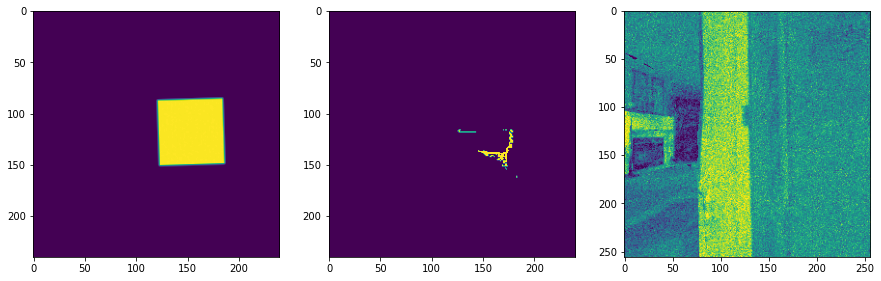

In [25]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax.imshow(global_input[0,0,:,:].cpu())
ax2.imshow(one_env.map[120:360,120:360])#nn.MaxPool2d(args.global_downscaling)(torch.from_numpy(one_env.map).unsqueeze_(0))[0])
ax3.imshow(obs_rgb.cpu()[0][1])
print(global_goals)

In [26]:
start = [120,50]
goal = [200,200]
planning_window = [0, 400, 0, 400]
grid = planner_inputs[0]['map_pred']
explored = planner_inputs[0]['exp_pred']

In [27]:
one_env.start_240_240 = start
one_env.goal_240_240 = goal
# Get short-term goal
print(grid.shape,start,goal,planning_window,' SHAPE_MAP START GOAL PLAN_WIND')
stg = one_env._get_stg(grid, explored, start, np.copy(goal), planning_window)

dist_to_goal = pu.get_l2_distance(goal[0], start[0], goal[1], start[1])*5./100.

(stg_x, stg_y) = stg
one_env.stg = [stg_x, stg_y]

(240, 240) [120, 50] [200, 200] [0, 400, 0, 400]  SHAPE_MAP START GOAL PLAN_WIND


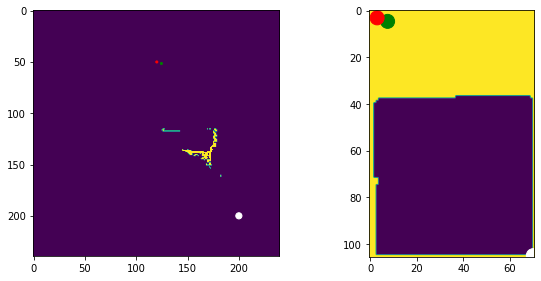

In [28]:
f = plt.figure(figsize=(15,10))
circ2 = Circle((one_env.start_240_240[0],one_env.start_240_240[1]),1,color='red')
circ5 = Circle((one_env.goal_240_240[0],one_env.goal_240_240[1]),3,color='white')
circ6 = Circle((one_env.stg[0],one_env.stg[1]),1,color='green')
circ111 = Circle((one_env.local_goal_x_y[0],one_env.local_goal_x_y[1]),3,color='green')
circ22 = Circle((one_env.goal_to_planer[0]-one_env.local_map_frame[2]+1,one_env.goal_to_planer[1]-one_env.local_map_frame[0]+1),3,color='white')
circ33 = Circle((one_env.start_240_240[0]-one_env.local_map_frame[2]+1,one_env.start_240_240[1]-one_env.local_map_frame[0]+1),3,color='red')

ax2 = f.add_subplot(231)
ax5 = f.add_subplot(232)
ax2.imshow(one_env.map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]])
ax2.add_patch(circ2)
ax2.add_patch(circ5)
ax2.add_patch(circ6)

ax5.imshow(one_env.traversible)
ax5.add_patch(circ111)
ax5.add_patch(circ22)
ax5.add_patch(circ33)

In [29]:
total_num_steps = 0
start = time.time()
for iii in range(50):
    
 #   obs, info = one_env.reset()
 #   step = 0
 #   init_map_and_pose()
    total_num_steps+=1
    
    last_obs = obs_rgb.detach()
    
    output = one_env.get_short_term_goal(planner_inputs[0])
    
    local_masks = l_masks
    local_goals = torch.from_numpy(output[:-1]).to(device).long()
    

    local_rec_states = local_rec_states.detach_()
    
    

    #start = one_env.start_240_240
    goal = one_env.goal_240_240
    #dist_to_goal = pu.get_l2_distance(goal[0], start[0], goal[1], start[1])*5./100.
    #print(int(output[2]),output[0],output[1],' Fol_action,action,angle,dist_goal')

    torch.set_grad_enabled(False)
    
    obs, reward, done, info = one_env.step(action=int(output[2]))
    
    

    obs_rgb = torch.from_numpy(np.expand_dims(obs['rgb'], axis=0)).float().to(device)
    trux,truy,goalx,goaly = [(one_env.trux+12)/args.map_size_cm*48000], [(one_env.truy+12)/args.map_size_cm*48000], [(one_env.goalx+12)/args.map_size_cm*48000], [(one_env.goaly+12)/args.map_size_cm*48000] 
    global_goals = [[int(goalx[i]),int(goaly[i])] for i in range(len(goalx))]
    
    if int(output[2])==0:
        print('RESTART')
        last_obs=obs_rgb.detach()
        obs, info = one_env.reset()
        init_map_and_pose()
        local_rec_states = torch.zeros(1, l_hidden_size).to(device)
        
    for env_idx in range(1):
        env_obs = obs_rgb[env_idx].to("cpu")
        env_poses = torch.from_numpy(np.asarray(
            info['sensor_pose']
        )).float().to("cpu")
        env_gt_fp_projs = torch.from_numpy(np.asarray(
            info['fp_proj']
        )).unsqueeze(0).float().to("cpu")
        env_gt_fp_explored = torch.from_numpy(np.asarray(
            info['fp_explored']
        )).unsqueeze(0).float().to("cpu")
        env_gt_pose_err = torch.from_numpy(np.asarray(
            info['pose_err']
        )).float().to("cpu")
        slam_memory.push(
            (last_obs[0].cpu(), env_obs, env_poses),
            (env_gt_fp_projs, env_gt_fp_explored, env_gt_pose_err))    

    l_masks = torch.FloatTensor([0 if done else 1]).to(device)
    g_masks *= l_masks
    poses = torch.from_numpy(np.asarray(
                    [info['sensor_pose']])).float().to(device)

    _, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
            nslam_module(last_obs, obs_rgb, poses, local_map[:, 0, :, :],
                         local_map[:, 1, :, :], local_pose, build_maps=True)
    locs = local_pose.cpu().numpy()
    planner_pose_inputs[:, :3] = locs + origins
    local_map[:, 2, :, :].fill_(0.)  # Resetting current location channel
    for e in range(num_scenes):
        r, c = locs[e, 1], locs[e, 0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        local_map[e, 2:, loc_r - 2:loc_r + 3, loc_c - 2:loc_c + 3] = 1.
    # ------------------------------------------------------------------
    for e in range(1):
        full_map[0,:, lmb[0, 0]:lmb[0, 1], lmb[0, 2]:lmb[0, 3]] = \
            local_map[0]
        full_pose[e] = local_pose[e] + \
                       torch.from_numpy(origins[e]).to(device).float()
        locs = full_pose[e].cpu().numpy()
        r, c = locs[1], locs[0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                          (local_w, local_h),
                                          (full_w, full_h), args)

        planner_pose_inputs[e, 3:] = lmb[e]
        origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                      lmb[e][0] * args.map_resolution / 100.0, 0.]

        local_map[e] = full_map[e, :,
                       lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
        local_pose[e] = full_pose[e] - \
                        torch.from_numpy(origins[e]).to(device).float()
    locs = local_pose.cpu().numpy()
    for e in range(num_scenes):
        global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)
    global_input[:, 0:4, :, :] = local_map
    global_input[:, 4:, :, :] = \
        nn.MaxPool2d(args.global_downscaling)(full_map)

    # Get short term goal
    planner_inputs = [{} for e in range(num_scenes)]
    for e, p_input in enumerate(planner_inputs):
        p_input['map_pred'] = one_env.map[lmb[0,0]:lmb[0,1],lmb[0,2]:lmb[0,3]]#local_map[e, 0, :, :].cpu().numpy()
        p_input['exp_pred'] = one_env.explored_map[lmb[0,0]:lmb[0,1],lmb[0,2]:lmb[0,3]]#local_map[e, 1, :, :].cpu().numpy()
        p_input['pose_pred'] = planner_pose_inputs[e]
        p_input['goal'] = global_goals[e]

    step+=1
    
  #  kartinka = one_env.draw_full() 

  #  explored_map,envs_map = one_env.explored_map, one_env.map

    draw_full()
    
    ### TRAINING
    torch.set_grad_enabled(True)
    
    if args.train_slam and len(slam_memory) > args.slam_batch_size:
        for _ in range(args.slam_iterations):
            inputs, outputs = slam_memory.sample(args.slam_batch_size)
            b_obs_last, b_obs, b_poses = inputs
            gt_fp_projs, gt_fp_explored, gt_pose_err = outputs

            b_obs = b_obs.to(device)
            b_obs_last = b_obs_last.to(device)
            b_poses = b_poses.to(device)

            gt_fp_projs = gt_fp_projs.to(device)
            gt_fp_explored = gt_fp_explored.to(device)
            gt_pose_err = gt_pose_err.to(device)

            b_proj_pred, b_fp_exp_pred, _, _, b_pose_err_pred, _ = \
                nslam_module(b_obs_last, b_obs, b_poses,
                             None, None, None,
                             build_maps=False)
            loss = 0
            if args.proj_loss_coeff > 0:
                proj_loss = F.binary_cross_entropy(b_proj_pred,
                                                   gt_fp_projs)
                costs.append(proj_loss.item())
                loss += args.proj_loss_coeff * proj_loss

            if args.exp_loss_coeff > 0:
                exp_loss = F.binary_cross_entropy(b_fp_exp_pred,
                                                  gt_fp_explored)
                exp_costs.append(exp_loss.item())
                loss += args.exp_loss_coeff * exp_loss

            if args.pose_loss_coeff > 0:
                pose_loss = torch.nn.MSELoss()(b_pose_err_pred,
                                               gt_pose_err)
                pose_costs.append(args.pose_loss_coeff *
                                  pose_loss.item())
                loss += args.pose_loss_coeff * pose_loss

            if args.train_slam:
                slam_optimizer.zero_grad()
                loss.backward()
                slam_optimizer.step()

            del b_obs_last, b_obs, b_poses
            del gt_fp_projs, gt_fp_explored, gt_pose_err
            del b_proj_pred, b_fp_exp_pred, b_pose_err_pred
          
    # Finish Training
    torch.set_grad_enabled(False)
    if total_num_steps % args.log_interval == 0:
        end = time.time()
        time_elapsed = time.gmtime(end - start)
        log = " ".join([
            "Time: {0:0=2d}d".format(time_elapsed.tm_mday - 1),
            "{},".format(time.strftime("%Hh %Mm %Ss", time_elapsed)),
            "num timesteps {},".format(total_num_steps *
                                       num_scenes),
            "FPS {},".format(int(total_num_steps * num_scenes \
                                 / (end - start)))
        ])

        log += "\n\tRewards:"


        log += "\n\tLosses:"


        if args.train_slam:
            log += " ".join([
                " SLAM Loss proj/exp/pose:"
                "{:.4f}/{:.4f}/{:.4f}".format(
                    np.mean(costs),
                    np.mean(exp_costs),
                    np.mean(pose_costs))
            ])

        print(log)
        logging.info(log)
    

Time: 00d 00h 00m 03s, num timesteps 10, FPS 2,
	Rewards:
	Losses: SLAM Loss proj/exp/pose:nan/nan/nan
Time: 00d 00h 00m 06s, num timesteps 20, FPS 2,
	Rewards:
	Losses: SLAM Loss proj/exp/pose:nan/nan/nan
Time: 00d 00h 00m 10s, num timesteps 30, FPS 2,
	Rewards:
	Losses: SLAM Loss proj/exp/pose:nan/nan/nan
Time: 00d 00h 00m 14s, num timesteps 40, FPS 2,
	Rewards:
	Losses: SLAM Loss proj/exp/pose:nan/nan/nan
Time: 00d 00h 00m 17s, num timesteps 50, FPS 2,
	Rewards:
	Losses: SLAM Loss proj/exp/pose:nan/nan/nan


In [30]:
print(one_env.local_goal_x_y)
print(one_env.goal_to_planer)
print(one_env.start_240_240)
print(one_env.goal_240_240)
print(one_env.stg)

[ 96.5 116.5]
[60 39]
[120, 120]
[60, 39]
[117.5, 116.5]


In [31]:
!ffmpeg -framerate 1 -pattern_type glob -i '/root/ANM_final/img/*.png' -c:v libx264 -r 120 -pix_fmt yuv420p /root/ANM_final/out.mp4 -y

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [32]:
map_pred = one_env.map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]]
exp_pred = one_env.explored_map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]]
grid = np.rint(map_pred)
explored = np.rint(exp_pred)
start_x, start_y, start_o, gx1, gx2, gy1, gy2 = planner_pose_inputs[0]
gx1, gx2, gy1, gy2 = int(gx1), int(gx2), int(gy1), int(gy2)
planning_window = [gx1, gx2, gy1, gy2]
    # Get last loc ground truth pose
last_start_x, last_start_y = one_env.last_loc_gt[0], one_env.last_loc_gt[1]
r, c = last_start_y, last_start_x
last_start = [int(r * 100.0/args.map_resolution- gx1),
              int(c * 100.0/args.map_resolution - gy1)]
last_start = pu.threshold_poses(last_start, one_env.visited_gt.shape)
# Get curr loc
curr_loc = [start_x, start_y, start_o]
r, c = start_y, start_x
start = [int(r * 100.0/args.map_resolution - gx1),
         int(c * 100.0/args.map_resolution - gy1)]
start = pu.threshold_poses(start, grid.shape)
#visited = np.copy(one_env.visited)
one_env.visited[gx1:gx2, gy1:gy2][start[0]-2:start[0]+3,
                                       start[1]-2:start[1]+3] = 1
steps = 25
#visited_vis = np.copy(one_env.visited_vis)
for i in range(steps):
    x = int(last_start[0] + (start[0] - last_start[0]) * (i+1) / steps)
    y = int(last_start[1] + (start[1] - last_start[1]) * (i+1) / steps)
    one_env.visited_vis[gx1:gx2, gy1:gy2][x, y] = 1
# Get goal
goal = np.copy(planner_inputs[0]['goal'])
goal[0]= goal[0]-gy1
goal[1]= goal[1]-gx1
print(goal)
goal = pu.threshold_poses(goal, grid.shape)    
stg = one_env._get_stg(grid, explored, start, np.copy(goal), planning_window)
gt_action = one_env._get_gt_action(1 - one_env.explorable_map, start,
                                            [int(stg[0]), int(stg[1])],
                                            planning_window, start_o)
(stg_x, stg_y) = stg
relative_dist = pu.get_l2_distance(stg_x, start[0], stg_y, start[1])
relative_dist = relative_dist*5./100.
angle_st_goal = math.degrees(math.atan2(stg_y - start[0],
                                        stg_x - start[1]))
angle_agent = (start_o)%360.0
if angle_agent > 180:
    angle_agent -= 360

relative_angle = (angle_agent - angle_st_goal)%360.0
if relative_angle > 180:
    relative_angle -= 360
print(stg,relative_dist,angle_st_goal,relative_angle,gt_action)

[54 36]


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [33]:
one_env.explorable_map

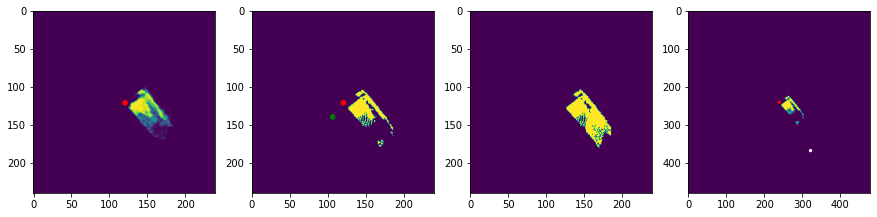

In [40]:
f = plt.figure(figsize=(15,10))
circ = Circle((local_pose[0][0]/args.map_size_cm*48000,local_pose[0][1]/args.map_size_cm*48000),3,color='red')
circ2 = Circle((trux[0]-120-(lmb[0,2]-120),truy[0]-120-(lmb[0,0]-120)),3,color='red')
circ5 = Circle((goalx[0]-120-(lmb[0,2]-120),goaly[0]-120-(lmb[0,0]-120)),3,color='white')
circ3 = Circle((trux[0],truy[0]),3,color='red')
circ4 = Circle((goalx[0],goaly[0]),3,color='white')
circ6 = Circle((stg[0],stg[1]),3,color='green')
ax = f.add_subplot(241)
ax2 = f.add_subplot(242)
ax3 = f.add_subplot(243)
ax4 = f.add_subplot(244)
ax.imshow(global_input[0,0,:,:].cpu())
ax.add_patch(circ)
ax2.imshow(one_env.map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]])#nn.MaxPool2d(args.global_downscaling)(torch.from_numpy(one_env.map).unsqueeze_(0))[0])
ax2.add_patch(circ2)
ax2.add_patch(circ5)
ax2.add_patch(circ6)
ax3.imshow(one_env.explored_map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]])
ax4.imshow(one_env.map)
ax4.add_patch(circ3)
ax4.add_patch(circ4)

In [41]:
print(goalx,goaly)
print(goalx[0]-120-(lmb[0,2]-120),goaly[0]-120-(lmb[0,0]-120))

[322.11597442626953] [368.162841796875]
203.11597442626953 248.162841796875


In [48]:
last_obs = obs_rgb.detach()
local_masks = l_masks
#local_goals = output[:, :-1].to(device).long()

map_pred = one_env.map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]]
exp_pred = one_env.explored_map[lmb[0,0]:lmb[0, 1],lmb[0, 2]:lmb[0, 3]]
grid = np.rint(map_pred)
explored = np.rint(exp_pred)
start_x, start_y, start_o, gx1, gx2, gy1, gy2 = planner_pose_inputs[0]
gx1, gx2, gy1, gy2 = int(gx1), int(gx2), int(gy1), int(gy2)
planning_window = [gx1, gx2, gy1, gy2]
    # Get last loc ground truth pose
last_start_x, last_start_y = one_env.last_loc_gt[0], one_env.last_loc_gt[1]
r, c = last_start_y, last_start_x
last_start = [int(r * 100.0/args.map_resolution- gx1),
              int(c * 100.0/args.map_resolution - gy1)]
last_start = pu.threshold_poses(last_start, one_env.visited_gt.shape)
# Get curr loc
curr_loc = [start_x, start_y, start_o]
r, c = start_y, start_x
start = [int(r * 100.0/args.map_resolution - gx1),
         int(c * 100.0/args.map_resolution - gy1)]
start = pu.threshold_poses(start, grid.shape)
#visited = np.copy(one_env.visited)
one_env.visited[gx1:gx2, gy1:gy2][start[0]-2:start[0]+3,
                                  start[1]-2:start[1]+3] = 1
steps = 25
#visited_vis = np.copy(one_env.visited_vis)
for i in range(steps):
    x = int(last_start[0] + (start[0] - last_start[0]) * (i+1) / steps)
    y = int(last_start[1] + (start[1] - last_start[1]) * (i+1) / steps)
    one_env.visited_vis[gx1:gx2, gy1:gy2][x, y] = 1
# Get goal
goal = np.copy(planner_inputs[0]['goal'])
goal[0]= goal[0]-gy1
goal[1]= goal[1]-gx1
goal = pu.threshold_poses(goal, grid.shape)   
print(start,goal,planning_window)
#stg = one_env._get_stg(grid, explored, start, np.copy(goal), planning_window)

[120, 120] [203 239] [120, 360, 119, 359]


[120, 120] [203 239] [120, 360, 119, 359]
103 118 180 186  X!Y!
203 239 103 180 118 186  GOAL X12!Y12!
[186 180]  GOAL INIT
69 78  given goal
[3, 18]  given start
[4.5, 22.5]  short res goal
[106.5, 139.5]
3 18  start


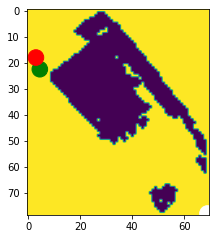

In [62]:
[gx1, gx2, gy1, gy2] = planning_window
goale = np.copy(goal[:])

print(start,goale,planning_window)   
x1 = min(start[0], goale[0])
x2 = max(start[0], goale[0])
y1 = min(start[1], goale[1])
y2 = max(start[1], goale[1])

dist = pu.get_l2_distance(goale[0], start[0], goale[1], start[1])
buf = max(20., dist)
x1 = max(1, int(x1 - buf))
x2 = min(grid.shape[0]-1, int(x2 + buf))
y1 = max(1, int(y1 - buf))
y2 = min(grid.shape[1]-1, int(y2 + buf))

rows = explored.sum(1)
rows[rows>0] = 1
ex1 = np.argmax(rows)
ex2 = len(rows) - np.argmax(np.flip(rows))

cols = explored.sum(0)
cols[cols>0] = 1
ey1 = np.argmax(cols)
ey2 = len(cols) - np.argmax(np.flip(cols))

ex1 = min(int(start[0]) - 2, ex1)
ex2 = max(int(start[0]) + 2, ex2)
ey1 = min(int(start[1]) - 2, ey1)
ey2 = max(int(start[1]) + 2, ey2)

x1 = max(x1, ex1)
x2 = min(x2, ex2)
y1 = max(y1, ey1)
y2 = min(y2, ey2)
print(x1,y1,x2,y2,' X!Y!')
traversible = skimage.morphology.binary_dilation(grid[x1:x2, y1:y2],one_env.selem) != True
#traversible[one_env.collison_map[gx1:gx2, gy1:gy2][x1:x2, y1:y2] == 1] = 0
traversible[one_env.visited[gx1:gx2, gy1:gy2][x1:x2, y1:y2] == 1] = 1
traversible[int(start[0]-x1)-1:int(start[0]-x1)+2,
                    int(start[1]-y1)-1:int(start[1]-y1)+2] = 1
print(goale[0],goale[1],x1,x2,y1,y2,' GOAL X12!Y12!')
if goale[0]-2 > y1 and goale[0]+3 < y2\
    and goale[1]-2 > x1 and goale[1]+3 < x2:
    traversible[int(goale[0]-y1)-2:int(goale[0]-y1)+3,
            int(goale[1]-x1)-2:int(goale[1]-x1)+3] = 1
else:
    goale[0] = min(max(y1, goale[0]), y2)
    goale[1] = min(max(x1, goale[1]), x2)
print(goale,' GOAL INIT')    
def add_boundary(mat):
    h, w = mat.shape
    new_mat = np.ones((h+2,w+2))
    new_mat[1:h+1,1:w+1] = mat
    return new_mat

#plt.imshow(traversible)
f = plt.figure(figsize=(15,10))

traversible = add_boundary(traversible)  
print(goale[0]-y1+1,goale[1]-x1+1, ' given goal')

planner = FMMPlanner(traversible, 360//one_env.dt)

reachable = planner.set_goal([goale[0]-y1+1,goale[1]-x1+1])
stg_x, stg_y =  start[0] - y1 + 1,start[1] - x1 + 1

for i in range(one_env.args.short_goal_dist):
    print([stg_x, stg_y], ' given start')
    stg_x, stg_y, replan = planner.get_short_term_goal([stg_y, stg_x])
    print([stg_y, stg_x],' short res goal')
    circ111 = Circle((stg_y,stg_x),3,color='green')
if replan:
    stg_x, stg_y = start[0], start[1]
else:
    stg_x, stg_y = stg_y + x1 - 1, stg_x + y1 - 1
print([stg_x, stg_y])  

print(start[0]-y1+1,start[1]-x1+1,' start')
"""
"""
circ22 = Circle((goale[0]-y1+1,goale[1]-x1+1),3,color='white')
circ33 = Circle((start[0]-y1+1,start[1]-x1+1),3,color='red')
ax = f.add_subplot(241)
ax.imshow(traversible)
ax.add_patch(circ111)
ax.add_patch(circ22)
ax.add_patch(circ33)

In [1173]:
def get_mask(sx, sy, scale, step_size):
    size = int(step_size // scale) * 2 + 1
    mask = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if ((i + 0.5) - (size // 2 + sx)) ** 2 + ((j + 0.5) - (size // 2 + sy)) ** 2 <= \
                    step_size ** 2:
                mask[i, j] = 1
    return mask


def get_dist(sx, sy, scale, step_size):
    size = int(step_size // scale) * 2 + 1
    mask = np.zeros((size, size)) + 1e-10
    for i in range(size):
        for j in range(size):
            if ((i + 0.5) - (size // 2 + sx)) ** 2 + ((j + 0.5) - (size // 2 + sy)) ** 2 <= \
                    step_size ** 2:
                mask[i, j] = max(5, (((i + 0.5) - (size // 2 + sx)) ** 2 +
                                     ((j + 0.5) - (size // 2 + sy)) ** 2) ** 0.5)
    return mask

In [1287]:
state = np.copy(np.array([start[1] - x1 + 1,start[0] - y1 + 1]))
print(state)
scale = planner.scale * 1.
state = [x / scale for x in state]

planner.du = 5
planner.step_size = 5
dx, dy = state[0] - int(state[0]), state[1] - int(state[1])
mask = get_mask(dx, dy, scale, planner.step_size)
dist_mask = get_dist(dx, dy, scale, planner.step_size)

state = [int(x) for x in state]



dist = np.pad(planner.fmm_dist, planner.du,
              'constant', constant_values=planner.fmm_dist.shape[0] ** 2)
subset = dist[state[0]:state[0] + 2 * planner.du + 1,
         state[1]:state[1] + 2 * planner.du + 1]


assert subset.shape[0] == 2 * planner.du + 1 and \
       subset.shape[1] == 2 * planner.du + 1, \
    "Planning error: unexpected subset shape {}".format(subset.shape)

subset *= mask
subset += (1 - mask) * planner.fmm_dist.shape[0] ** 2
subset -= subset[planner.du, planner.du]
ratio1 = subset / dist_mask
subset[ratio1 < -1.5] = 1


trav = np.pad(planner.traversible, planner.du,
                      'constant', constant_values=0)
                      

subset_trav = trav[state[0]:state[0] + 2 * planner.du + 1,
              state[1]:state[1] + 2 * planner.du + 1]
#"""             
traversible_ma = np.ma.masked_values(subset_trav * 1, 0)

goal_x, goal_y = planner.du+5, planner.du+5
traversible_ma[goal_y, goal_x] = 0
dd = skfmm.distance(traversible_ma, dx=1)

dd_mask = np.invert(np.isnan(np.ma.filled(dd, np.nan)))

dd = np.ma.filled(dd, np.max(dd) + 1)
 
subset_fmm_dist = dd


subset_fmm_dist[subset_fmm_dist < 4] = 4.
subset = subset / subset_fmm_dist
subset[subset < -1.5] = 1
(stg_x, stg_y) = np.unravel_index(np.argmin(subset), subset.shape)
print((stg_x + state[0] - planner.du) * scale + 0.5, \
               (stg_y + state[1] - planner.du) * scale + 0.5)
#"""               

[43  3]


'             \ntraversible_ma = np.ma.masked_values(subset_trav * 1, 0)\n\ngoal_x, goal_y = planner.du+5, planner.du+5\ntraversible_ma[goal_y, goal_x] = 0\ndd = skfmm.distance(traversible_ma, dx=1)\n\ndd_mask = np.invert(np.isnan(np.ma.filled(dd, np.nan)))\n\ndd = np.ma.filled(dd, np.max(dd) + 1)\n \nsubset_fmm_dist = dd\n\n\nsubset_fmm_dist[subset_fmm_dist < 4] = 4.\nsubset = subset / subset_fmm_dist\nsubset[subset < -1.5] = 1\n(stg_x, stg_y) = np.unravel_index(np.argmin(subset), subset.shape)\nprint((stg_x + state[0] - planner.du) * scale + 0.5,                (stg_y + state[1] - planner.du) * scale + 0.5)\n'

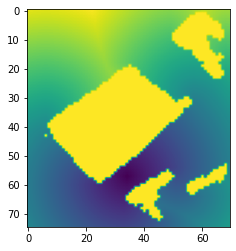

In [1290]:
plt.imshow(planner.fmm_dist)

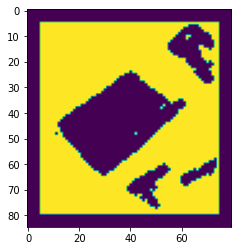

In [1291]:
plt.imshow(trav)

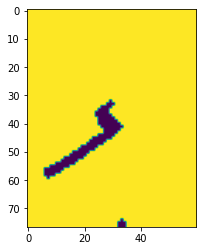

In [757]:
traversible = skimage.morphology.binary_dilation(grid[x1:x2, y1:y2],one_env.selem) != True
traversible[one_env.collison_map[gx1:gx2, gy1:gy2][x1:x2, y1:y2] == 1] = 0
traversible[one_env.visited[gx1:gx2, gy1:gy2][x1:x2, y1:y2] == 1] = 1
traversible[int(start[0]-x1)-1:int(start[0]-x1)+2,
                    int(start[1]-y1)-1:int(start[1]-y1)+2] = 1
plt.imshow(traversible)

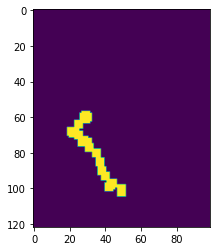

In [705]:
plt.imshow(one_env.visited[gx1:gx2, gy1:gy2][y1:y2, x1:x2])

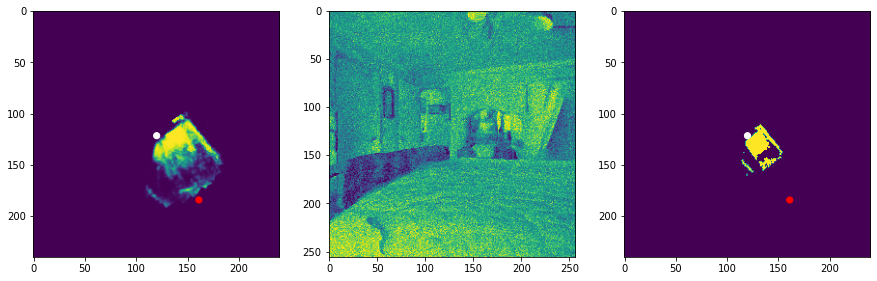

In [53]:
#print(output[2].numpy().astype(int))
#print(short_goal)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
circ = Circle((trux[0],truy[0]),3,color='white')
circ2 = Circle((goalx[0],goaly[0]),3,color='red')
#circ3 = Circle((short_goal[0],short_goal[1]),3,color='green')
circ4 = Circle((trux[0],truy[0]),3,color='white')
circ5 = Circle((goalx[0],goaly[0]),3,color='red')
#circ6 = Circle((short_goal[0],short_goal[1]),3,color='green')
ax.imshow(local_map[0][0].cpu())
ax2.imshow(obs['rgb'][0])
ax3.imshow(nn.MaxPool2d(args.global_downscaling)(torch.from_numpy(envs_map).unsqueeze_(0))[0])
ax.add_patch(circ)
ax.add_patch(circ2)
#ax.add_patch(circ3)
ax3.add_patch(circ4)
ax3.add_patch(circ5)
#ax3.add_patch(circ6)

In [ ]:
obs, info = one_env.reset()

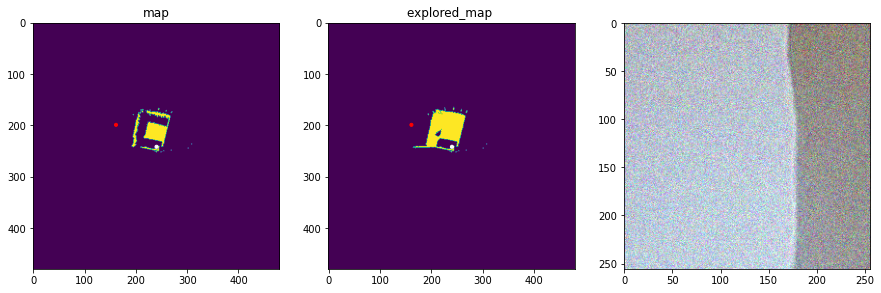

In [13]:
for i in range(10):
    obs, reward, done, info = one_env.step(action=2)
draw()

In [18]:
map_pred = one_env.map
exp_pred = one_env.explored_map
grid = np.rint(map_pred)
explored = np.rint(exp_pred)

In [14]:
obs, reward, done, info = one_env.step(action=0)

0.0024545097351074217
2
-0.008190879821777344
2
-0.008764514923095703
2
-0.009698638916015625
2
-0.022105464935302736
2
-0.007014522552490235
2
-0.049182186126708986
2
-0.005234012603759766
2
0.00972341537475586
2
-0.029196033477783205
2


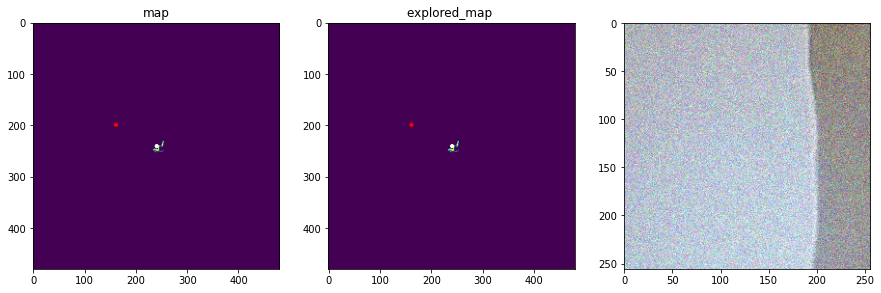

In [10]:
for i in range(10):
    best_action = follower.get_next_action(one_env.habitat_env.current_episode.goals[0].position)
    if best_action==0 or best_action==None:
        print('DONE')
        break
    obs, reward, done, info = one_env.step(action=best_action)
    print(reward)
    print(best_action)
draw()

# Test multiple env

In [6]:
def init_map_and_pose(done):
    full_map[[done]].fill_(0.)
    full_pose[[done]].fill_(0.)
    full_pose[done, :2] = args.map_size_cm / 100.0 / 2.0

    locs = full_pose.cpu().numpy()
    planner_pose_inputs[done, :3] = locs[done]
    for e in done:
        r, c = locs[e, 1], locs[e, 0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        full_map[e, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.0

        lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                          (local_w, local_h),
                                          (full_w, full_h), args)

        planner_pose_inputs[e, 3:] = lmb[e]
        origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                      lmb[e][0] * args.map_resolution / 100.0, 0.]

    for e in done:
        local_map[e] = full_map[e, :, lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
        local_pose[e] = full_pose[e] - \
                        torch.from_numpy(origins[e]).to(device).float()

In [7]:
envs = VectorEnv(
    env_fn_args=tuple(
        tuple(zip(args_list, env_configs,
            range(args.num_processes)))))

In [8]:
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
l_observation_space = gym.spaces.Box(0, 255,
                                     (3,
                                      args.frame_width,
                                      args.frame_width), dtype='uint8')
l_hidden_size = args.local_hidden_size
# slam
nslam_module = Neural_SLAM_Module(args).to(device)
# Local policy
l_policy = Local_IL_Policy(l_observation_space.shape, envs.action_spaces[0].n,
                           recurrent=args.use_recurrent_local,
                           hidden_size=l_hidden_size,
                           deterministic=args.use_deterministic_local).to(device)
state_dict = torch.load('./periodic_608.slam',
                            map_location=lambda storage, loc: storage)
nslam_module.load_state_dict(state_dict)
state_dict = torch.load('./periodic_608.local',
                            map_location=lambda storage, loc: storage)
l_policy.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
num_scenes = args.num_processes
map_size = args.map_size_cm // args.map_resolution
full_w, full_h = map_size, map_size
local_w, local_h = int(full_w / args.global_downscaling), \
                   int(full_h / args.global_downscaling)
    # Initializing full and local map
full_map = torch.zeros(num_scenes, 4, full_w, full_h).float().to(device)
local_map = torch.zeros(num_scenes, 4, local_w, local_h).float().to(device)
    # Initial full and local pose
full_pose = torch.zeros(num_scenes, 3).float().to(device)
local_pose = torch.zeros(num_scenes, 3).float().to(device)
    # Origin of local map
origins = np.zeros((num_scenes, 3))
    # Local Map Boundaries
lmb = np.zeros((num_scenes, 4)).astype(int)
planner_pose_inputs = np.zeros((num_scenes, 7))

In [10]:
obs, infos = envs.reset()
done = [True for i in range(num_scenes)]
dones = [i for ii,i in enumerate(range(num_scenes)) if done[ii]]
init_map_and_pose(dones)
poses = torch.from_numpy(np.asarray(
    [infos[env_idx]['sensor_pose'] for env_idx
     in range(num_scenes)])).float().to(device)
obs_rgb = torch.from_numpy(np.array([i['rgb'] for i in obs])).float().to(device)

In [11]:
_, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
    nslam_module(obs_rgb, obs_rgb, poses, local_map[:, 0, :, :],
                 local_map[:, 1, :, :], local_pose)

/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [12]:
# Compute Global policy input
locs = local_pose.cpu().numpy()
global_input = torch.zeros(num_scenes, 8, local_w, local_h)
global_orientation = torch.zeros(num_scenes, 1).long()

for e in range(num_scenes):
    r, c = locs[e, 1], locs[e, 0]
    loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                    int(c * 100.0 / args.map_resolution)]

    local_map[e, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.
    global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)

global_input[:, 0:4, :, :] = local_map.detach()
global_input[:, 4:, :, :] = nn.MaxPool2d(args.global_downscaling)(full_map)

In [13]:
OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [(read_fn()+12)/args.map_size_cm*48000 for read_fn in envs._connection_read_fns]
trux,truy,goalx,goaly = OBSERVATION_SPACE_COMMAND
global_goals = [[int(goalx[i]),int(goaly[i])] for i in range(len(goalx))]

In [14]:
OBSERVATION_SPACE_COMMAND = ['explored_map','map']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns]
explored_map,envs_map = OBSERVATION_SPACE_COMMAND

In [15]:
# Compute planner inputs
planner_inputs = [{} for e in range(num_scenes)]
for e, p_input in enumerate(planner_inputs):
    p_input['goal'] = global_goals[e]
    p_input['map_pred'] = envs_map[e][lmb[e,0]:lmb[e,1],lmb[e,2]:lmb[e,3]]#global_input[e, 0, :, :].detach().cpu().numpy()
    p_input['exp_pred'] = explored_map[e][lmb[e,0]:lmb[e,1],lmb[e,2]:lmb[e,3]]#global_input[e, 1, :, :].detach().cpu().numpy()
    p_input['pose_pred'] = planner_pose_inputs[e]
local_rec_states = torch.zeros(num_scenes, l_hidden_size).to(device)    

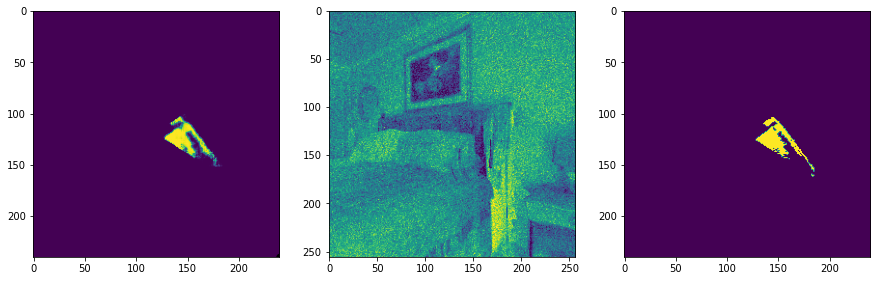

In [16]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
circ = Circle((trux[0],truy[0]),3,color='black')
circ2 = Circle((goalx[0],goaly[0]),3,color='red')
#circ3 = Circle((short_goal[0][0],short_goal[0][1]),3,color='white')
circ4 = Circle((trux[0]*2,truy[0]*2),3,color='black')
circ5 = Circle((goalx[0]*2,goaly[0]*2),3,color='red')
ax.imshow(local_map[0][0].cpu())
ax2.imshow(obs[0]['rgb'][0])
ax3.imshow(planner_inputs[0]['map_pred'])
ax.add_patch(circ)
ax.add_patch(circ2)
#ax.add_patch(circ3)
ax3.add_patch(circ4)
ax3.add_patch(circ5)

In [17]:
OBSERVATION_SPACE_COMMAND = ['start_240_240','goal_240_240']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns] 
start = OBSERVATION_SPACE_COMMAND[0]
goal = OBSERVATION_SPACE_COMMAND[1]

[2 1]
[7.22582175 6.00333241]
[2 3]
[7.25430906 6.01685134]
[2 1]
[7.22582175 6.01331855]
[2 1]
[7.22582175 6.04069532]
[2 3]
[7.19756903 6.07474279]
[2 1]
[7.19756903 6.07474279]
[2 1]
[7.16955368 6.11882342]
[2 3]
[7.14177849 6.18465844]
[2 1]
[7.11424627 6.18465844]
[2 2]
[7.11424627 6.26418391]


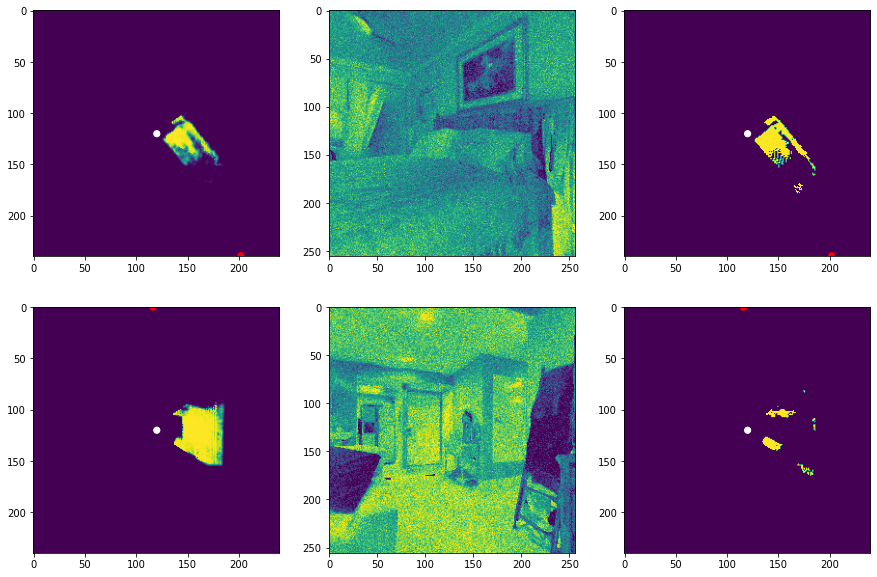

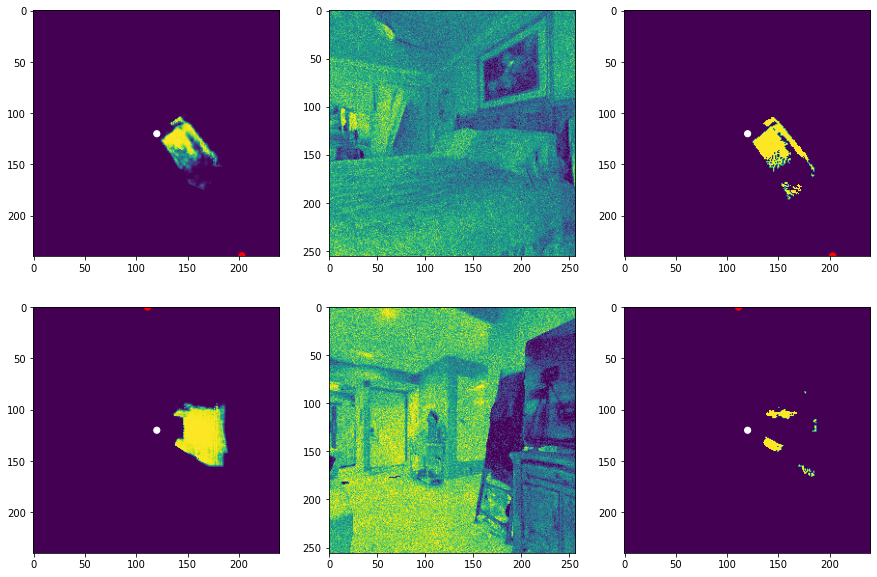

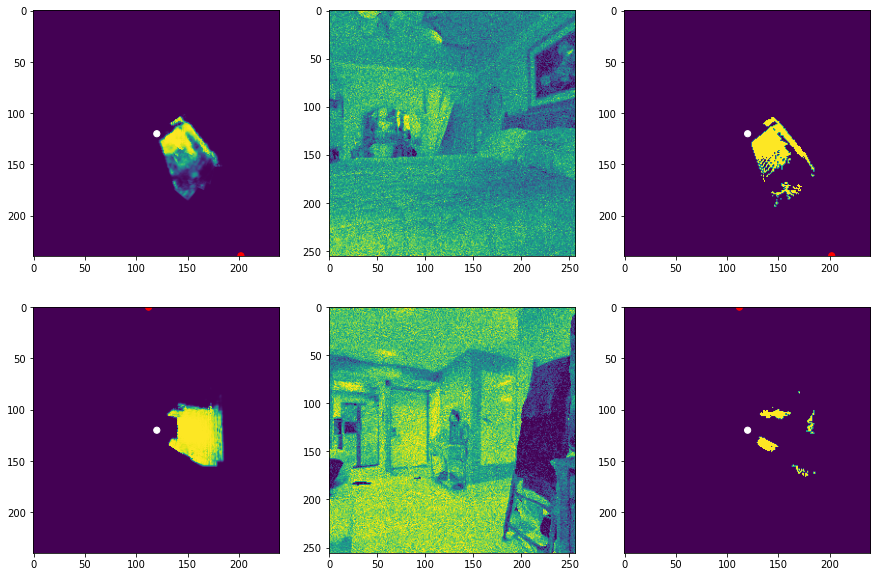

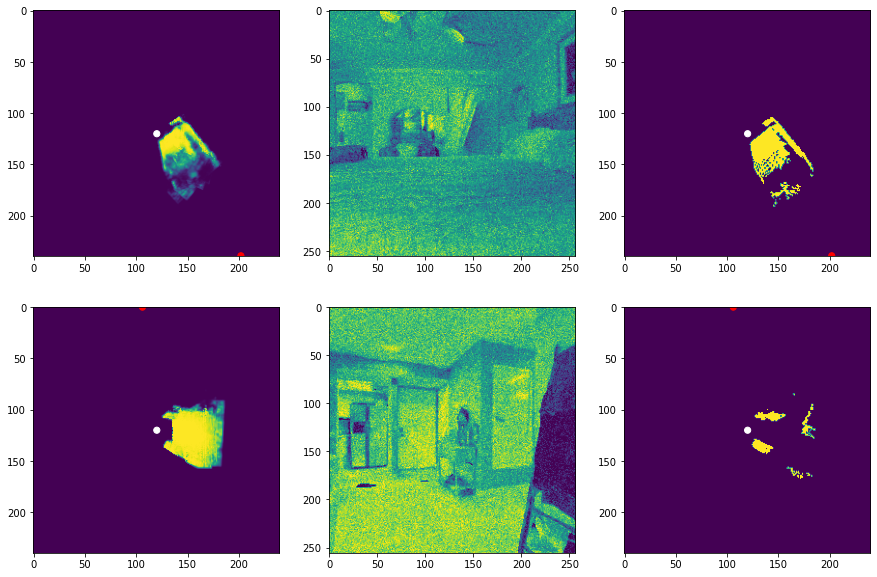

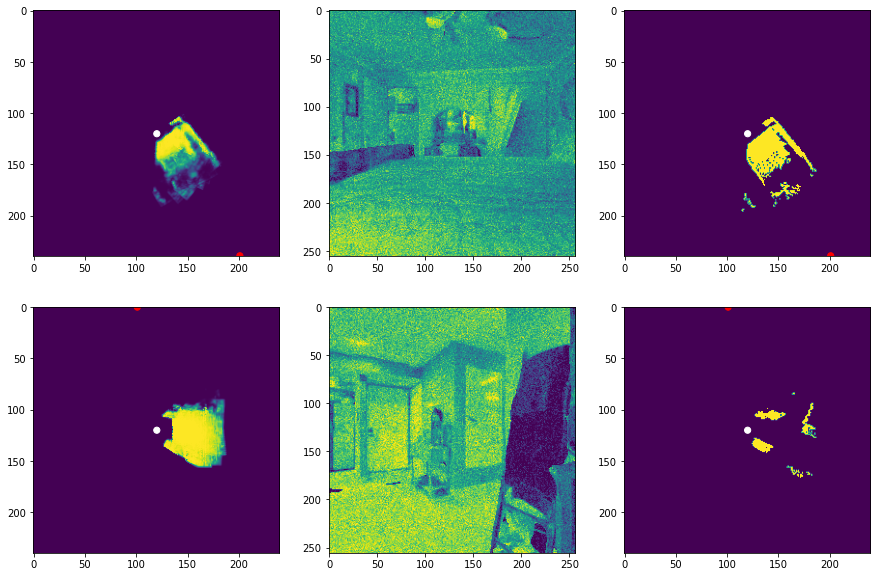

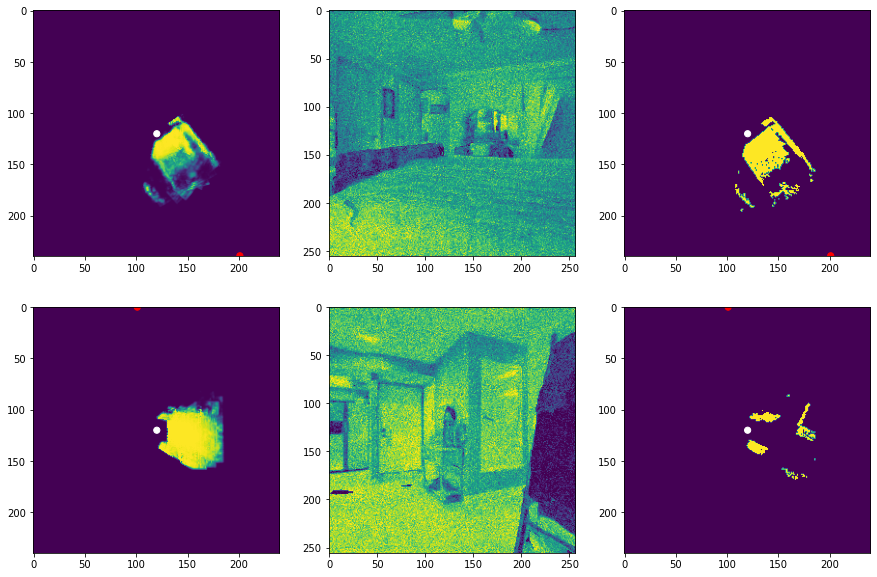

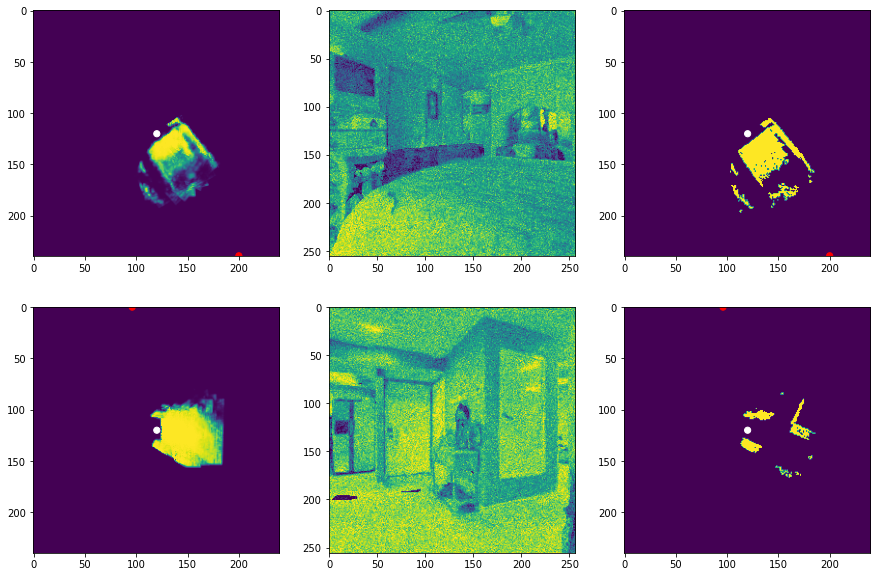

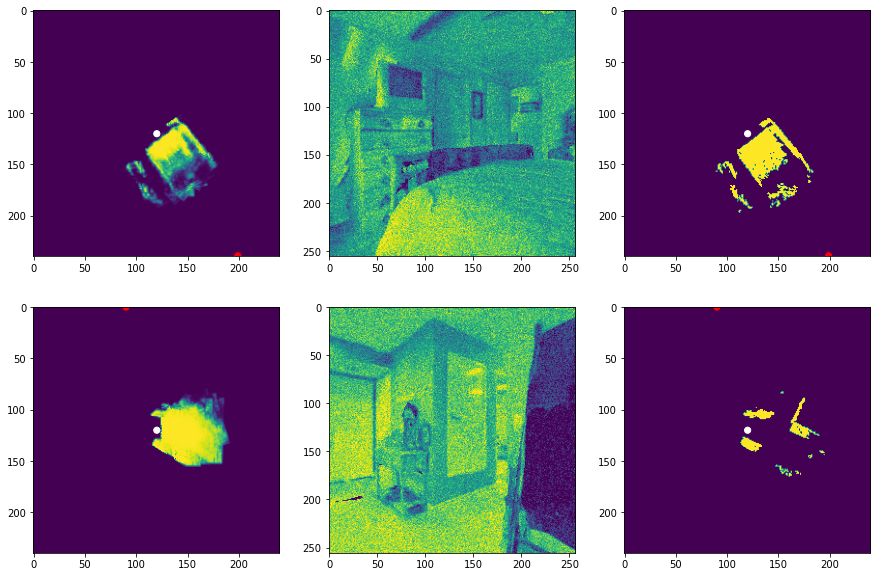

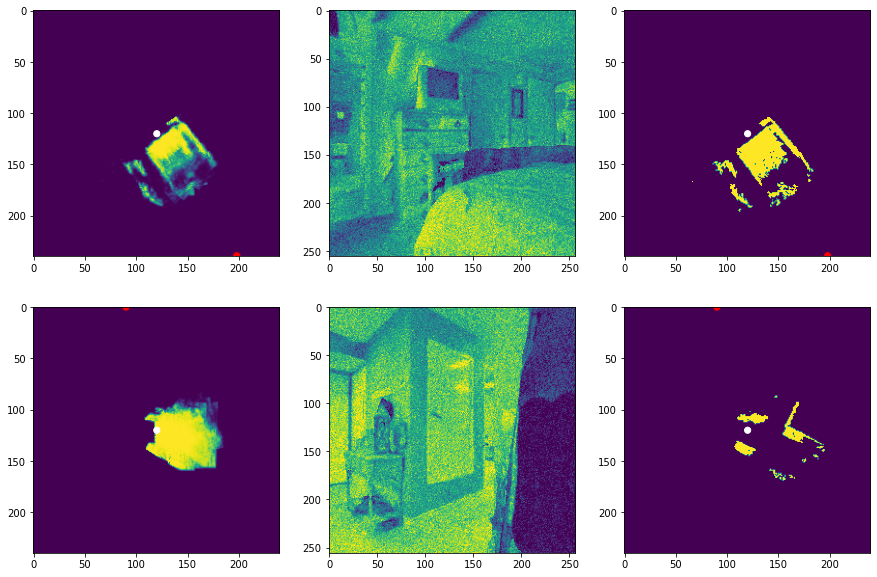

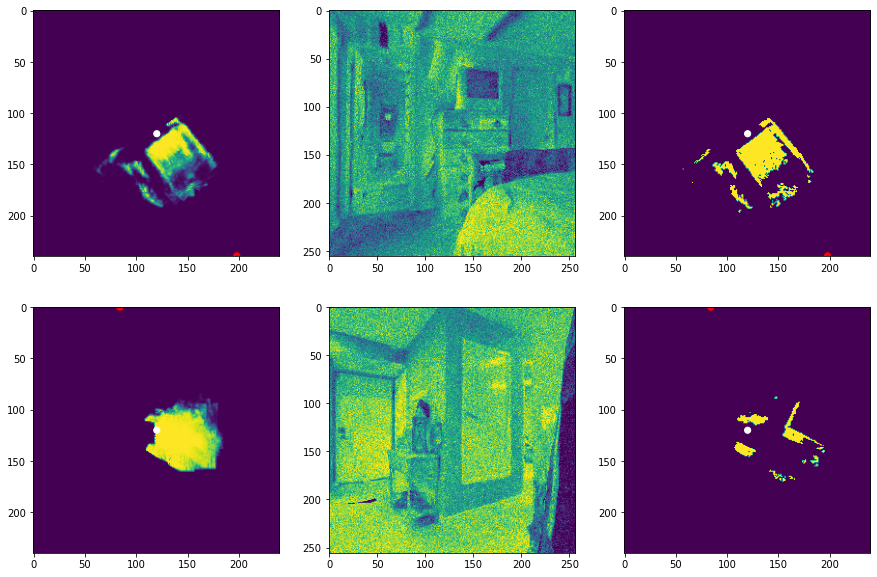

In [18]:
success = [0.]
spls = [0.]
for i in range(10):
    #l_action =[3,3,3,3]
    output = envs.get_short_term_goal(planner_inputs)
    l_action=output[:,2].astype(int)
    last_obs = obs_rgb.detach()
    
    
    for n in [ii for ii,i in enumerate(l_action) if l_action[ii]==0]:
        full_map[n] = torch.zeros(1, 4, full_w, full_h).float().to(device)
        local_map[n] = torch.zeros(1, 4, local_w, local_h).float().to(device)
        full_pose[n] = torch.zeros(1, 3).float().to(device)
        local_pose[n] = torch.zeros(1, 3).float().to(device)
    
    obs, rew, done, infos = envs.step(l_action)
    
    OBSERVATION_SPACE_COMMAND = ['start_240_240','goal_240_240']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns] 
    start = OBSERVATION_SPACE_COMMAND[0]
    goal = OBSERVATION_SPACE_COMMAND[1]
    
    dones = [i for ii,i in enumerate(range(num_scenes)) if done[ii]]
    if len(dones)>0:
                
        init_map_and_pose(dones)
        success += [i['success'] for ii,i in enumerate(infos) if ii in dones]
        spls += [i['spl'] for ii,i in enumerate(infos) if ii in dones]
        print(np.mean(success),np.mean(spls))
        
        poses = torch.from_numpy(np.asarray(
                    [infos[env_idx]['sensor_pose'] for env_idx
                     in range(num_scenes)])).float().to(device)
        obs_rgb = torch.from_numpy(np.array([i['rgb'] for i in obs])).float().to(device)

        local_map_restart = local_map.clone()
        local_pose_restart = local_pose.clone()

        _, _, local_map_restart[:, 0, :, :], local_map_restart[:, 1, :, :], _, local_pose_restart = \
            nslam_module(obs_rgb, obs_rgb, poses, local_map[:, 0, :, :],
                         local_map[:, 1, :, :], local_pose)


        locs = local_pose_restart.cpu().numpy()

        for e in dones:
            r, c = locs[e, 1], locs[e, 0]
            loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                            int(c * 100.0 / args.map_resolution)]

            local_map_restart[e, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.
            global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)
        global_input[dones, 0:4, :, :] = local_map_restart[dones].detach().cpu()
        global_input[dones, 4:, :, :] = nn.MaxPool2d(args.global_downscaling)(full_map[dones]).cpu()
        OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
        for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
            for write_fn in envs._connection_write_fns:
                write_fn((command, None))
            OBSERVATION_SPACE_COMMAND[i] = [(read_fn()+12)/args.map_size_cm*48000 for read_fn in envs._connection_read_fns]
        trux,truy,goalx,goaly = OBSERVATION_SPACE_COMMAND
        global_goals = [[int(goalx[i]),int(goaly[i])] for i in range(len(goalx))]


        #planner_inputs = [{} for e in dones]
        for e, p_input in enumerate(planner_inputs):
            if e in dones:
                p_input['goal'] = global_goals[e]
                p_input['map_pred'] = global_input[e, 0, :, :].detach().cpu().numpy()
                p_input['exp_pred'] = global_input[e, 1, :, :].detach().cpu().numpy()
                p_input['pose_pred'] = planner_pose_inputs[e]


    #       last_obs = obs_rgb.detach()
        local_rec_states[dones] = torch.zeros(len(dones), l_hidden_size).to(device)
        
        
    obs_rgb = torch.from_numpy(np.array([i['rgb'] for i in obs])).float().to(device)
    OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [(read_fn()+12)/args.map_size_cm*48000 for read_fn in envs._connection_read_fns]
    trux,truy,goalx,goaly = OBSERVATION_SPACE_COMMAND
    global_goals = [[int(goalx[i]),int(goaly[i])] for i in range(len(goalx))]
    l_masks = torch.FloatTensor([0 if x else 1 for x in done]).to(device)
    poses = torch.from_numpy(np.asarray(
                    [infos[env_idx]['sensor_pose'] for env_idx
                     in range(num_scenes)])).float().to(device)

    _, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
            nslam_module(last_obs, obs_rgb, poses, local_map[:, 0, :, :],
                         local_map[:, 1, :, :], local_pose, build_maps=True)
    locs = local_pose.cpu().numpy()
    planner_pose_inputs[:, :3] = locs + origins
    local_map[:, 2, :, :].fill_(0.)  # Resetting current location channel
    for e in range(num_scenes):
        r, c = locs[e, 1], locs[e, 0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        local_map[e, 2:, loc_r - 2:loc_r + 3, loc_c - 2:loc_c + 3] = 1.
    # ------------------------------------------------------------------
    #"""
    for e in range(num_scenes):
        full_map[e, :, lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]] = \
            local_map[e]
        full_pose[e] = local_pose[e] + \
                       torch.from_numpy(origins[e]).to(device).float()
        locs = full_pose[e].cpu().numpy()
        r, c = locs[1], locs[0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                          (local_w, local_h),
                                          (full_w, full_h), args)

        planner_pose_inputs[e, 3:] = lmb[e]
        origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                      lmb[e][0] * args.map_resolution / 100.0, 0.]

        local_map[e] = full_map[e, :,
                       lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
        local_pose[e] = full_pose[e] - \
                        torch.from_numpy(origins[e]).to(device).float()
    locs = local_pose.cpu().numpy()
    for e in range(num_scenes):
        global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)
    global_input[:, 0:4, :, :] = local_map
    global_input[:, 4:, :, :] = \
        nn.MaxPool2d(args.global_downscaling)(full_map)
    #"""    

    # Get short term goal
    planner_inputs = [{} for e in range(num_scenes)]
    for e, p_input in enumerate(planner_inputs):
        p_input['map_pred'] = envs_map[e][lmb[e,0]:lmb[e,1],lmb[e,2]:lmb[e,3]]#local_map[e, 0, :, :].cpu().numpy()
        p_input['exp_pred'] = explored_map[e][lmb[e,0]:lmb[e,1],lmb[e,2]:lmb[e,3]]#local_map[e, 1, :, :].cpu().numpy()
        p_input['pose_pred'] = planner_pose_inputs[e]
        p_input['goal'] = global_goals[e]


    OBSERVATION_SPACE_COMMAND = ['explored_map','map']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns]
    explored_map,envs_map = OBSERVATION_SPACE_COMMAND

    print(output[:,2].astype(int))
    print(output[:,1])
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(231)
    ax2 = f.add_subplot(232)
    ax3 = f.add_subplot(233)
    circ = Circle((start[0][0],start[0][1]),3,color='white')
    circ2 = Circle((goal[0][0],goal[0][1]),3,color='red')
    #circ3 = Circle((short_goal[0][0],short_goal[0][1]),3,color='green')
    circ4 = Circle((start[0][0],start[0][1]),3,color='white')
    circ5 = Circle((goal[0][0],goal[0][1]),3,color='red')
    #circ6 = Circle((short_goal[0][0],short_goal[0][1]),3,color='green')
    ax.imshow(local_map[0][0].cpu())
    ax2.imshow(obs[0]['rgb'][0])
    ax3.imshow(envs_map[0][lmb[0,0]:lmb[0,1],lmb[0,2]:lmb[0,3]])
    ax.add_patch(circ)
    ax.add_patch(circ2)
    #ax.add_patch(circ3)
    ax3.add_patch(circ4)
    ax3.add_patch(circ5)
    #ax3.add_patch(circ6)

    ax1 = f.add_subplot(234)
    ax21 = f.add_subplot(235)
    ax31 = f.add_subplot(236)
    circ1 = Circle((start[1][0],start[1][1]),3,color='white')
    circ21 = Circle((goal[1][0],goal[1][1]),3,color='red')
    #circ3 = Circle((short_goal[0][0],short_goal[0][1]),3,color='green')
    circ41 = Circle((start[1][0],start[1][1]),3,color='white')
    circ51 = Circle((goal[1][0],goal[1][1]),3,color='red')
    #circ6 = Circle((short_goal[0][0],short_goal[0][1]),3,color='green')
    ax1.imshow(local_map[1][1].cpu())
    ax21.imshow(obs[1]['rgb'][0])
    ax31.imshow(envs_map[1][lmb[1,0]:lmb[1,1],lmb[1,2]:lmb[1,3]])
    ax1.add_patch(circ1)
    ax1.add_patch(circ21)
    #ax.add_patch(circ3)
    ax31.add_patch(circ41)
    ax31.add_patch(circ51)
    #ax31.add_patch(circ6)

In [11]:
OBSERVATION_SPACE_COMMAND = ['stg']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns]
stg = OBSERVATION_SPACE_COMMAND[0]

# Multiple env

In [6]:
def init_map_and_pose(done):
    full_map[[done]]*=0.#.fill_(0.)
    full_pose[[done]]*=0.#.fill_(0.)
    full_pose[done, :2] = args.map_size_cm / 100.0 / 2.0

    locs = full_pose.cpu().numpy()
    planner_pose_inputs[done, :3] = locs[done]
    for e in done:
        r, c = locs[e, 1], locs[e, 0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        full_map[e, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.0

        lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                          (local_w, local_h),
                                          (full_w, full_h), args)

        planner_pose_inputs[e, 3:] = lmb[e]
        origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                      lmb[e][0] * args.map_resolution / 100.0, 0.]

    for e in done:
        local_map[e] = full_map[e, :, lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
        local_pose[e] = full_pose[e] - \
                        torch.from_numpy(origins[e]).to(device).float()

In [7]:
envs = VectorEnv(
    env_fn_args=tuple(
        tuple(zip(args_list, env_configs,
            range(args.num_processes)))))

In [8]:
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
l_observation_space = gym.spaces.Box(0, 255,
                                     (3,
                                      args.frame_width,
                                      args.frame_width), dtype='uint8')
l_hidden_size = args.local_hidden_size
# slam
nslam_module = Neural_SLAM_Module(args).to(device)
# Local policy
l_policy = Local_IL_Policy(l_observation_space.shape, envs.action_spaces[0].n,
                           recurrent=args.use_recurrent_local,
                           hidden_size=l_hidden_size,
                           deterministic=args.use_deterministic_local).to(device)
state_dict = torch.load('./periodic_12479.slam',
                            map_location=lambda storage, loc: storage)
nslam_module.load_state_dict(state_dict)
state_dict = torch.load('./periodic_12479.local',
                            map_location=lambda storage, loc: storage)
l_policy.load_state_dict(state_dict)
local_optimizer = get_optimizer(l_policy.parameters(),
                                args.local_optimizer)
slam_optimizer = get_optimizer(nslam_module.parameters(),
                               args.slam_optimizer)

In [9]:
num_scenes = args.num_processes
num_episodes = int(args.num_episodes)
device = args.device = torch.device("cuda:0" if args.cuda else "cpu")
policy_loss = 0

best_cost = 100000
costs = deque(maxlen=1000)
exp_costs = deque(maxlen=1000)
pose_costs = deque(maxlen=1000)

g_masks = torch.ones(num_scenes).float().to(device)
l_masks = torch.zeros(num_scenes).float().to(device)

best_local_loss = np.inf
best_g_reward = -np.inf

if args.eval:
    traj_lengths = args.max_episode_length // args.num_local_steps
    explored_area_log = np.zeros((num_scenes, num_episodes, traj_lengths))
    explored_ratio_log = np.zeros((num_scenes, num_episodes, traj_lengths))

g_episode_rewards = deque(maxlen=1000)

l_action_losses = deque(maxlen=1000)

g_value_losses = deque(maxlen=1000)
g_action_losses = deque(maxlen=1000)
g_dist_entropies = deque(maxlen=1000)

per_step_g_rewards = deque(maxlen=1000)

g_process_rewards = np.zeros((num_scenes))

In [10]:
torch.set_grad_enabled(False)
map_size = args.map_size_cm // args.map_resolution
full_w, full_h = map_size, map_size
local_w, local_h = int(full_w / args.global_downscaling), \
                   int(full_h / args.global_downscaling)

# Initializing full and local map
full_map = torch.zeros(num_scenes, 4, full_w, full_h).float().to(device)
local_map = torch.zeros(num_scenes, 4, local_w, local_h).float().to(device)

# Initial full and local pose
full_pose = torch.zeros(num_scenes, 3).float().to(device)
local_pose = torch.zeros(num_scenes, 3).float().to(device)

full_map.fill_(0.)
full_pose.fill_(0.)

# Origin of local map
origins = np.zeros((num_scenes, 3))

# Local Map Boundaries
lmb = np.zeros((num_scenes, 4)).astype(int)
planner_pose_inputs = np.zeros((num_scenes, 7))

In [11]:
obs, infos = envs.reset()
done = [True for i in range(num_scenes)]
dones = [i for ii,i in enumerate(range(num_scenes)) if done[ii]]
init_map_and_pose(dones)
poses = torch.from_numpy(np.asarray(
    [infos[env_idx]['sensor_pose'] for env_idx
     in range(num_scenes)])).float().to(device)
obs_rgb = torch.from_numpy(np.array([i['rgb'] for i in obs])).float().to(device)

In [12]:
# Global policy observation space
g_observation_space = gym.spaces.Box(0, 1,
                                     (8,
                                      local_w,
                                      local_h), dtype='uint8')
# Global policy action space
g_action_space = gym.spaces.Box(low=0.0, high=1.0,
                                shape=(2,), dtype=np.float32)
# Local policy observation space
l_observation_space = gym.spaces.Box(0, 255,
                                     (3,
                                      args.frame_width,
                                      args.frame_width), dtype='uint8')
# Local and Global policy recurrent layer sizes
l_hidden_size = args.local_hidden_size
g_hidden_size = args.global_hidden_size

In [13]:
slam_memory = FIFOMemory(args.slam_memory_size)

In [14]:
# Predict map from frame 1:
poses = torch.from_numpy(np.asarray(
    [infos[env_idx]['sensor_pose'] for env_idx
     in range(num_scenes)])
).float().to(device)

obs_rgb = torch.from_numpy(np.array([i['rgb'] for i in obs])).float().to(device)
_, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
    nslam_module(obs_rgb, obs_rgb, poses, local_map[:, 0, :, :],
                 local_map[:, 1, :, :], local_pose)

/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [15]:
# Compute Global policy input
locs = local_pose.cpu().numpy()
global_input = torch.zeros(num_scenes, 8, local_w, local_h)
global_orientation = torch.zeros(num_scenes, 1).long()

for e in range(num_scenes):
    r, c = locs[e, 1], locs[e, 0]
    loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                    int(c * 100.0 / args.map_resolution)]

    local_map[e, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.
    global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)

global_input[:, 0:4, :, :] = local_map.detach()
global_input[:, 4:, :, :] = nn.MaxPool2d(args.global_downscaling)(full_map)

In [16]:
OBSERVATION_SPACE_COMMAND = ['explored_map','map']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns]
explored_map,envs_map = OBSERVATION_SPACE_COMMAND

In [17]:
OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [(read_fn()+12)/args.map_size_cm*48000 for read_fn in envs._connection_read_fns]
trux,truy,goalx,goaly = OBSERVATION_SPACE_COMMAND
global_goals = [[int(goalx[i]),int(goaly[i])] for i in range(len(goalx))]
OBSERVATION_SPACE_COMMAND = ['start_240_240','goal_240_240']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns] 
start = OBSERVATION_SPACE_COMMAND[0]
goal = OBSERVATION_SPACE_COMMAND[1]

In [18]:
global_goals

[[161, 198],
 [266, 192],
 [254, 205],
 [270, 152],
 [236, 108],
 [227, 345],
 [206, 152],
 [209, 104]]

In [19]:
# Compute planner inputs
planner_inputs = [{} for e in range(num_scenes)]
for e, p_input in enumerate(planner_inputs):
    p_input['goal'] = global_goals[e]
    p_input['map_pred'] = global_input[e, 0, :, :].detach().cpu().numpy()
    p_input['exp_pred'] = global_input[e, 1, :, :].detach().cpu().numpy()
    p_input['pose_pred'] = planner_pose_inputs[e]
    
local_rec_states = torch.zeros(num_scenes, l_hidden_size).to(device) 
total_num_steps = -1
g_reward = 0

torch.set_grad_enabled(False)
writer = TensorboardWriter('./tb')

In [20]:
from torch.autograd import Variable
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)

In [ ]:
step = 0
start = time.time()
list_suc = []
list_spl = []
for ep_num in range(num_episodes*args.max_episode_length):
    step+=1
    total_num_steps += 1
    g_step = (step // args.num_local_steps) % args.num_global_steps
    eval_g_step = step // args.num_local_steps + 1
    l_step = step % args.num_local_steps
    
    
    last_obs = obs_rgb.detach()
    output = envs.get_short_term_goal(planner_inputs)
    l_action=output[:,2].astype(int)
    
    local_masks = l_masks
    local_goals = torch.from_numpy(output[:, :-1]).to(device).long()
    if args.train_local:
        torch.set_grad_enabled(True)
        
    action, action_prob, local_rec_states = l_policy(
            obs_rgb,
            local_rec_states,
            local_masks,
            extras=local_goals)
    
   # if args.train_local:
    action_target = torch.from_numpy(np.array(l_action)).long().to(device)
    policy_loss += nn.CrossEntropyLoss()(action_prob, action_target)
    torch.set_grad_enabled(False)
            
    # ------------------------------------------------------------------
    # Train Local Policy
  #  if (l_step + 1) % args.local_policy_update_freq == 0 \
  #          and args.train_local:
    local_optimizer.zero_grad()
    policy_loss.backward()
    local_optimizer.step()
    l_action_losses.append(policy_loss.item())
    policy_loss = 0
    local_rec_states = local_rec_states.detach_()
    # ------------------------------------------------------------------      
    
    obs, rew, done, infos = envs.step(l_action)
     
    
        
    obs_rgb = torch.from_numpy(np.array([i['rgb'] for i in obs])).float().to(device)
    
    
    
    OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [(read_fn()+12)/args.map_size_cm*48000 for read_fn in envs._connection_read_fns]
    trux,truy,goalx,goaly = OBSERVATION_SPACE_COMMAND
    global_goals = [[int(goalx[i]),int(goaly[i])] for i in range(len(goalx))]   
    
    l_masks = torch.FloatTensor([0 if x else 1 for x in done]).to(device)
    g_masks *= l_masks
    
    for ii,i in enumerate(l_action):
        if i==0:
            last_obs[ii]=obs_rgb[ii].detach()
            
    dones = [i for ii,i in enumerate(range(num_scenes)) if done[ii]]
    if len(dones)>0:    
        print(dones)
        init_map_and_pose(dones)
        local_rec_states[dones] = local_rec_states[dones]*0        
    
    # Neural SLAM Module
    if args.train_slam:
        # Add frames to memory
        for env_idx in range(num_scenes):
            env_obs = obs_rgb[env_idx].to("cpu")
            env_poses = torch.from_numpy(np.asarray(
                infos[env_idx]['sensor_pose']
            )).float().to("cpu")
            env_gt_fp_projs = torch.from_numpy(np.asarray(
                infos[env_idx]['fp_proj']
            )).unsqueeze(0).float().to("cpu")
            env_gt_fp_explored = torch.from_numpy(np.asarray(
                infos[env_idx]['fp_explored']
            )).unsqueeze(0).float().to("cpu")
            env_gt_pose_err = torch.from_numpy(np.asarray(
                infos[env_idx]['pose_err']
            )).float().to("cpu")
            slam_memory.push(
                (last_obs[env_idx].cpu(), env_obs, env_poses),
                (env_gt_fp_projs, env_gt_fp_explored, env_gt_pose_err))
    
    
    
    poses = torch.from_numpy(np.asarray(
            [infos[env_idx]['sensor_pose'] for env_idx
             in range(num_scenes)])).float().to(device)

    _, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
            nslam_module(last_obs, obs_rgb, poses, local_map[:, 0, :, :],
                         local_map[:, 1, :, :], local_pose, build_maps=True)

    locs = local_pose.cpu().numpy()
    planner_pose_inputs[:, :3] = locs + origins
    local_map[:, 2, :, :].fill_(0.)  # Resetting current location channel
    for e in range(num_scenes):
        r, c = locs[e, 1], locs[e, 0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        local_map[e, 2:, loc_r - 2:loc_r + 3, loc_c - 2:loc_c + 3] = 1.
    # ------------------------------------------------------------------
    for e in range(num_scenes):
        full_map[e, :, lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]] = \
            local_map[e]
        full_pose[e] = local_pose[e] + \
                       torch.from_numpy(origins[e]).to(device).float()

        locs = full_pose[e].cpu().numpy()
        r, c = locs[1], locs[0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]
        lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                          (local_w, local_h),
                                          (full_w, full_h), args)
        planner_pose_inputs[e, 3:] = lmb[e]
        origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                      lmb[e][0] * args.map_resolution / 100.0, 0.]
        local_map[e] = full_map[e, :,
                       lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
        local_pose[e] = full_pose[e] - \
                        torch.from_numpy(origins[e]).to(device).float()

    locs = local_pose.cpu().numpy()
    for e in range(num_scenes):
        global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)
    global_input[:, 0:4, :, :] = local_map
    global_input[:, 4:, :, :] = \
        nn.MaxPool2d(args.global_downscaling)(full_map)

    # Get short term goal
    planner_inputs = [{} for e in range(num_scenes)]
    for e, p_input in enumerate(planner_inputs):
        p_input['map_pred'] = envs_map[e][lmb[e,0]:lmb[e,1],lmb[e,2]:lmb[e,3]]#local_map[e, 0, :, :].cpu().numpy()
        p_input['exp_pred'] = explored_map[e][lmb[e,0]:lmb[e,1],lmb[e,2]:lmb[e,3]]#local_map[e, 1, :, :].cpu().numpy()
        p_input['pose_pred'] = planner_pose_inputs[e]
        p_input['goal'] = global_goals[e]
        
        
    OBSERVATION_SPACE_COMMAND = ['explored_map','map']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns]
    explored_map,envs_map = OBSERVATION_SPACE_COMMAND
    
    ### TRAINING
    torch.set_grad_enabled(True)
    # Train Neural SLAM Module
    if args.train_slam and len(slam_memory) > args.slam_batch_size:
        for _ in range(args.slam_iterations):
            inputs, outputs = slam_memory.sample(args.slam_batch_size)
            b_obs_last, b_obs, b_poses = inputs
            gt_fp_projs, gt_fp_explored, gt_pose_err = outputs

            b_obs = b_obs.to(device)
            b_obs_last = b_obs_last.to(device)
            b_poses = b_poses.to(device)

            gt_fp_projs = gt_fp_projs.to(device)
            gt_fp_explored = gt_fp_explored.to(device)
            gt_pose_err = gt_pose_err.to(device)

            b_proj_pred, b_fp_exp_pred, _, _, b_pose_err_pred, _ = \
                nslam_module(b_obs_last, b_obs, b_poses,
                             None, None, None,
                             build_maps=False)
            loss = 0
            if args.proj_loss_coeff > 0:
                proj_loss = F.binary_cross_entropy(b_proj_pred,
                                                   gt_fp_projs)
                costs.append(proj_loss.item())
                loss += args.proj_loss_coeff * proj_loss

            if args.exp_loss_coeff > 0:
                exp_loss = F.binary_cross_entropy(b_fp_exp_pred,
                                                  gt_fp_explored)
                exp_costs.append(exp_loss.item())
                loss += args.exp_loss_coeff * exp_loss

            if args.pose_loss_coeff > 0:
                pose_loss = torch.nn.MSELoss()(b_pose_err_pred,
                                               gt_pose_err)
                pose_costs.append(args.pose_loss_coeff *
                                  pose_loss.item())
                loss += args.pose_loss_coeff * pose_loss

            if args.train_slam:
                slam_optimizer.zero_grad()
                loss.backward()
                slam_optimizer.step()

            del b_obs_last, b_obs, b_poses
            del gt_fp_projs, gt_fp_explored, gt_pose_err
            del b_proj_pred, b_fp_exp_pred, b_pose_err_pred
          
    # Finish Training
    torch.set_grad_enabled(False)
    # ------------------------------------------------------------------

    # ------------------------------------------------------------------      
    # Logging
    if total_num_steps % args.log_interval == 0:
        end = time.time()
        time_elapsed = time.gmtime(end - start)
        log = " ".join([
            "Time: {0:0=2d}d".format(time_elapsed.tm_mday - 1),
            "{},".format(time.strftime("%Hh %Mm %Ss", time_elapsed)),
            "num timesteps {},".format(total_num_steps *
                                       num_scenes),
            "FPS {},".format(int(total_num_steps * num_scenes \
                                 / (end - start)))
        ])

        log += "\n\tRewards:"

        log += " ".join([
            " Succsess, SPL:",
            "{:.4f}/{:.4f},".format(
                np.mean(list_suc[-100:]),
                np.mean(list_spl[-100:]))
        ])

        log += "\n\tLosses:"

        if args.train_local and len(l_action_losses) > 0:
            log += " ".join([
                " Local Loss:",
                "{:.3f},".format(
                    np.mean(l_action_losses))
            ])
        writer.add_scalar(
                        "Local Loss",
                        np.mean(l_action_losses),
                        step)   


        if args.train_slam and len(costs) > 0:
            log += " ".join([
                " SLAM Loss proj/exp/pose:"
                "{:.4f}/{:.4f}/{:.4f}".format(
                    np.mean(costs),
                    np.mean(exp_costs),
                    np.mean(pose_costs))
            ])
        writer.add_scalar(
                        "SLAM Loss proj",
                        np.mean(costs),
                        step)
        writer.add_scalar(
                        "SLAM Loss exp",
                        np.mean(exp_costs),
                        step)     

        print(log)
        logging.info(log)
    # ------------------------------------------------------------------

    # ------------------------------------------------------------------
    # Save best models
        # Save Neural SLAM Model
    if np.mean(costs) < best_cost and not args.eval:
        best_cost = np.mean(costs)
        torch.save(nslam_module.state_dict(),
                   os.path.join(log_dir, "model_best.slam"))

    # Save Local Policy Model
    if np.mean(l_action_losses) <= best_local_loss and not args.eval:
        torch.save(l_policy.state_dict(),
                   os.path.join(log_dir, "model_best.local"))

        best_local_loss = np.mean(l_action_losses)

    # Save periodic models
    if step % 100==0:
        #step = total_num_steps * num_scenes
        if args.train_slam:
            torch.save(nslam_module.state_dict(),
                       os.path.join(dump_dir,
                                    "periodic_{}.slam".format(step)))
        if args.train_local:
            torch.save(l_policy.state_dict(),
                       os.path.join(dump_dir,
                                    "periodic_{}.local".format(step)))

/opt/conda/envs/habitat/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/envs/habitat/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Time: 00d 00h 00m 00s, num timesteps 0, FPS 0,
	Rewards: Succsess, SPL: nan/nan,
	Losses: Local Loss: 1.366,
Time: 00d 00h 00m 08s, num timesteps 80, FPS 9,
	Rewards: Succsess, SPL: nan/nan,
	Losses: Local Loss: 1.213, SLAM Loss proj/exp/pose:0.0795/0.0856/0.0000
Time: 00d 00h 00m 34s, num timesteps 160, FPS 4,
	Rewards: Succsess, SPL: nan/nan,
	Losses: Local Loss: 1.081, SLAM Loss proj/exp/pose:0.0639/0.0662/0.0000
Time: 00d 00h 01m 00s, num timesteps 240, FPS 3,
	Rewards: Succsess, SPL: nan/nan,
	Losses: Local Loss: 1.086, SLAM Loss proj/exp/pose:0.0604/0.0631/0.0000
[2]
Time: 00d 00h 01m 28s, num timesteps 320, FPS 3,
	Rewards: Succsess, SPL: nan/nan,
	Losses: Local Loss: 1.081, SLAM Loss proj/exp/pose:0.0570/0.0607/0.0000
Time: 00d 00h 01m 54s, num timesteps 400, FPS 3,
	Rewards: Succsess, SPL: nan/nan,
	Losses: Local Loss: 1.045, SLAM Loss proj/exp/pose:0.0545/0.0593/0.0000
Time: 00d 00h 02m 21s, num timesteps 480, FPS 3,
	Rewards: Succsess, SPL: nan/nan,
	Losses: Local Loss: 1.04

In [2]:
torch.save(nslam_module.state_dict(),
                       os.path.join('.',
                                    "periodic_{}.slam".format(step)))
torch.save(l_policy.state_dict(),
                       os.path.join('.',
                                    "periodic_{}.local".format(step)))

NameError: name 'torch' is not defined

In [35]:
best_local_loss

inf

In [30]:
dump_dir

'./tmp/dump/exp1/'

In [27]:
[i['goal'] for i in planner_inputs]

[[322, 368], [91, 338], [273, 381], [236, 108], [386, 349], [146, 239]]

In [ ]:
print(one_env.local_goal_x_y)
print(one_env.goal_to_planer)
print(one_env.start_240_240)
print(one_env.goal_240_240)

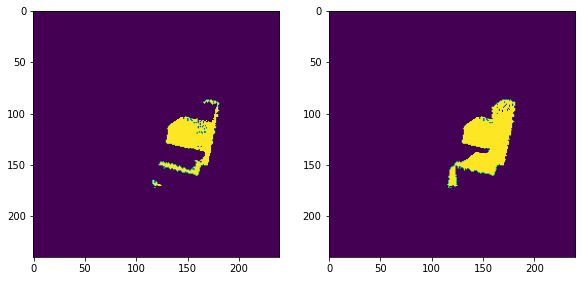

In [30]:
ind = 0
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax.imshow(planner_inputs[ind]['map_pred'])
ax2.imshow(planner_inputs[ind]['exp_pred'])
print(planner_inputs)

NameError: name 'start_ep' is not defined

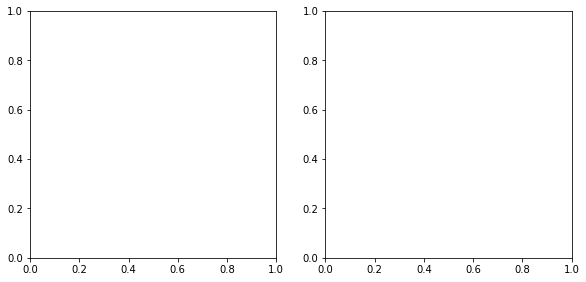

In [28]:
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
circ = Circle((start_ep[0][0],start_ep[0][1]),3,color='red')
circ2 = Circle((goal_ep[0][0],goal_ep[0][1]),3,color='white')
circ3 = Circle((stg_ep[0][0],stg_ep[0][1]),3,color='green')
ax.imshow(local_map[0, 0, :, :].cpu().numpy())
ax2.imshow(envs_map[0][lmb[0,0]:lmb[0,1],lmb[0,2]:lmb[0,3]])
ax2.add_patch(circ)
ax2.add_patch(circ2)
ax2.add_patch(circ3)

In [24]:
step = 0
start = time.time()
list_suc = []
list_spl = []
for ep_num in range(num_episodes*args.max_episode_length):
    step+=1
    
    total_num_steps += 1
    g_step = (step // args.num_local_steps) % args.num_global_steps
    eval_g_step = step // args.num_local_steps + 1
    l_step = step % args.num_local_steps
    
    last_obs = obs_rgb.detach()
    output = envs.get_short_term_goal(planner_inputs)
    l_action=output[:,2].astype(int)
    
    # Local Policy
    local_masks = l_masks
   
    local_goals = torch.from_numpy(output[:, :-1]).to(device).long()
    
    if args.train_local:
        torch.set_grad_enabled(True)

    action, action_prob, local_rec_states = l_policy(
            obs_rgb,
            local_rec_states,
            local_masks,
            extras=local_goals)
    
    OBSERVATION_SPACE_COMMAND = ['start_240_240','goal_240_240']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns] 
    start_ep = OBSERVATION_SPACE_COMMAND[0]
    goal_ep = OBSERVATION_SPACE_COMMAND[1]
    #print(start_ep)
    
    if args.train_local:
        action_target = torch.from_numpy(np.array(l_action)).long().to(device)
        policy_loss += nn.CrossEntropyLoss()(action_prob, action_target)
        torch.set_grad_enabled(False)
            
    # ------------------------------------------------------------------
    # Train Local Policy
    if (l_step + 1) % args.local_policy_update_freq == 0 \
            and args.train_local:
        local_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        local_optimizer.step()
        l_action_losses.append(policy_loss.item())
        policy_loss = 0
        local_rec_states = local_rec_states.detach_()
    # ------------------------------------------------------------------      

        
    obs, rew, done, infos = envs.step(l_action)

    
      
    for n in [ii for ii,i in enumerate(l_action) if l_action[ii]==0]:
        print(n)
        full_map[n]*=0 #= torch.zeros(1, 4, full_w, full_h).float().to(device)
        local_map[n]*=0 #= torch.zeros(1, 4, local_w, local_h).float().to(device)
        full_pose[n]*=0 #= torch.zeros(1, 3).float().to(device)
        local_pose[n]*=0 #= torch.zeros(1, 3).float().to(device)
    # ------------------------------------------------------------------
    
    
    suc = [i['success'] if done[ii] else None for ii,i in enumerate(infos)]
    for i in suc:
        if i is not None:
            list_suc.append(i)
    spl = [i['spl'] if done[ii] else None for ii,i in enumerate(infos)]
    for i in spl:
        if i is not None:
            list_spl.append(i)
    #print(len(list_suc),len(list_spl))
    
    OBSERVATION_SPACE_COMMAND = ['start_240_240','goal_240_240']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns] 
    start_pos = OBSERVATION_SPACE_COMMAND[0]
    goal_pos = OBSERVATION_SPACE_COMMAND[1]
    
    
    dones = [i for ii,i in enumerate(range(num_scenes)) if done[ii]]
    if len(dones)>0:
                
        init_map_and_pose(dones)
       # success += [i['success'] for ii,i in enumerate(infos) if ii in dones]
       # spls += [i['spl'] for ii,i in enumerate(infos) if ii in dones]
       # print(np.mean(success),np.mean(spls))
        
        poses = torch.from_numpy(np.asarray(
                    [infos[env_idx]['sensor_pose'] for env_idx
                     in range(num_scenes)])).float().to(device)
        obs_rgb = torch.from_numpy(np.array([i['rgb'] for i in obs])).float().to(device)

        local_map_restart = local_map.clone()
        local_pose_restart = local_pose.clone()

        _, _, local_map_restart[:, 0, :, :], local_map_restart[:, 1, :, :], _, local_pose_restart = \
            nslam_module(obs_rgb, obs_rgb, poses, local_map[:, 0, :, :],
                         local_map[:, 1, :, :], local_pose)


        locs = local_pose_restart.cpu().numpy()

        for e in dones:
            r, c = locs[e, 1], locs[e, 0]
            loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                            int(c * 100.0 / args.map_resolution)]

            local_map_restart[e, 2:, loc_r - 1:loc_r + 2, loc_c - 1:loc_c + 2] = 1.
            global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)
        global_input[dones, 0:4, :, :] = local_map_restart[dones].detach().cpu()
        global_input[dones, 4:, :, :] = nn.MaxPool2d(args.global_downscaling)(full_map[dones]).cpu()
        OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
        for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
            for write_fn in envs._connection_write_fns:
                write_fn((command, None))
            OBSERVATION_SPACE_COMMAND[i] = [(read_fn()+12)/args.map_size_cm*48000 for read_fn in envs._connection_read_fns]
        trux,truy,goalx,goaly = OBSERVATION_SPACE_COMMAND
        global_goals = [[int(goalx[i]),int(goaly[i])] for i in range(len(goalx))]


        #planner_inputs = [{} for e in dones]
        for e, p_input in enumerate(planner_inputs):
            if e in dones:
                p_input['goal'] = global_goals[e]
                p_input['map_pred'] = global_input[e, 0, :, :].detach().cpu().numpy()
                p_input['exp_pred'] = global_input[e, 1, :, :].detach().cpu().numpy()
                p_input['pose_pred'] = planner_pose_inputs[e]

        local_rec_states[dones] = local_rec_states[dones]*0
    

    obs_rgb = torch.from_numpy(np.array([i['rgb'] for i in obs])).float().to(device)
    OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [(read_fn()+12)/args.map_size_cm*48000 for read_fn in envs._connection_read_fns]
    trux,truy,goalx,goaly = OBSERVATION_SPACE_COMMAND
    global_goals = [[int(goalx[i]),int(goaly[i])] for i in range(len(goalx))]


    l_masks = torch.FloatTensor([0 if x else 1
                                     for x in done]).to(device)

    g_masks *= l_masks
    # ------------------------------------------------------------------
    # Reinitialize variables when episode ends
    #if step == args.max_episode_length - 1:  # Last episode step
    #    init_map_and_pose()
    #    del last_obs
    #    last_obs = obs_rgb.detach()
    # ------------------------------------------------------------------
    # Neural SLAM Module
    if args.train_slam:
        # Add frames to memory
        for env_idx in range(num_scenes):
            env_obs = obs_rgb[env_idx].to("cpu")
            env_poses = torch.from_numpy(np.asarray(
                infos[env_idx]['sensor_pose']
            )).float().to("cpu")
            env_gt_fp_projs = torch.from_numpy(np.asarray(
                infos[env_idx]['fp_proj']
            )).unsqueeze(0).float().to("cpu")
            env_gt_fp_explored = torch.from_numpy(np.asarray(
                infos[env_idx]['fp_explored']
            )).unsqueeze(0).float().to("cpu")
            env_gt_pose_err = torch.from_numpy(np.asarray(
                infos[env_idx]['pose_err']
            )).float().to("cpu")
            slam_memory.push(
                (last_obs[env_idx].cpu(), env_obs, env_poses),
                (env_gt_fp_projs, env_gt_fp_explored, env_gt_pose_err))

    poses = torch.from_numpy(np.asarray(
            [infos[env_idx]['sensor_pose'] for env_idx
             in range(num_scenes)])).float().to(device)

    _, _, local_map[:, 0, :, :], local_map[:, 1, :, :], _, local_pose = \
            nslam_module(last_obs, obs_rgb, poses, local_map[:, 0, :, :],
                         local_map[:, 1, :, :], local_pose, build_maps=True)

    locs = local_pose.cpu().numpy()
    planner_pose_inputs[:, :3] = locs + origins
    #print(locs)
    local_map[:, 2, :, :].fill_(0.)  # Resetting current location channel
    for e in range(num_scenes):
        r, c = locs[e, 1], locs[e, 0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        local_map[e, 2:, loc_r - 2:loc_r + 3, loc_c - 2:loc_c + 3] = 1.
    # ------------------------------------------------------------------
    for e in range(num_scenes):
        full_map[e, :, lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]] = \
            local_map[e]
        full_pose[e] = local_pose[e] + \
                       torch.from_numpy(origins[e]).to(device).float()

        locs = full_pose[e].cpu().numpy()
        r, c = locs[1], locs[0]
        loc_r, loc_c = [int(r * 100.0 / args.map_resolution),
                        int(c * 100.0 / args.map_resolution)]

        lmb[e] = get_local_map_boundaries((loc_r, loc_c),
                                          (local_w, local_h),
                                          (full_w, full_h), args)

        planner_pose_inputs[e, 3:] = lmb[e]
        origins[e] = [lmb[e][2] * args.map_resolution / 100.0,
                      lmb[e][0] * args.map_resolution / 100.0, 0.]

        local_map[e] = full_map[e, :,
                       lmb[e, 0]:lmb[e, 1], lmb[e, 2]:lmb[e, 3]]
        local_pose[e] = full_pose[e] - \
                        torch.from_numpy(origins[e]).to(device).float()

    locs = local_pose.cpu().numpy()
    for e in range(num_scenes):
        global_orientation[e] = int((locs[e, 2] + 180.0) / 5.)
    global_input[:, 0:4, :, :] = local_map
    global_input[:, 4:, :, :] = \
        nn.MaxPool2d(args.global_downscaling)(full_map)

    # Get short term goal
    planner_inputs = [{} for e in range(num_scenes)]
    for e, p_input in enumerate(planner_inputs):
        p_input['map_pred'] = envs_map[e][lmb[e,0]:lmb[e,1],lmb[e,2]:lmb[e,3]]#local_map[e, 0, :, :].cpu().numpy()
        p_input['exp_pred'] = explored_map[e][lmb[e,0]:lmb[e,1],lmb[e,2]:lmb[e,3]]#local_map[e, 1, :, :].cpu().numpy()
        p_input['pose_pred'] = planner_pose_inputs[e]
        p_input['goal'] = global_goals[e]
        
        
    OBSERVATION_SPACE_COMMAND = ['explored_map','map']
    for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
        for write_fn in envs._connection_write_fns:
            write_fn((command, None))
        OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns]
    explored_map,envs_map = OBSERVATION_SPACE_COMMAND

    ### TRAINING
    torch.set_grad_enabled(True)
    # ------------------------------------------------------------------
    # Train Neural SLAM Module
    if args.train_slam and len(slam_memory) > args.slam_batch_size:
        for _ in range(args.slam_iterations):
            inputs, outputs = slam_memory.sample(args.slam_batch_size)
            b_obs_last, b_obs, b_poses = inputs
            gt_fp_projs, gt_fp_explored, gt_pose_err = outputs

            b_obs = b_obs.to(device)
            b_obs_last = b_obs_last.to(device)
            b_poses = b_poses.to(device)

            gt_fp_projs = gt_fp_projs.to(device)
            gt_fp_explored = gt_fp_explored.to(device)
            gt_pose_err = gt_pose_err.to(device)

            b_proj_pred, b_fp_exp_pred, _, _, b_pose_err_pred, _ = \
                nslam_module(b_obs_last, b_obs, b_poses,
                             None, None, None,
                             build_maps=False)
            loss = 0
            if args.proj_loss_coeff > 0:
                proj_loss = F.binary_cross_entropy(b_proj_pred,
                                                   gt_fp_projs)
                costs.append(proj_loss.item())
                loss += args.proj_loss_coeff * proj_loss

            if args.exp_loss_coeff > 0:
                exp_loss = F.binary_cross_entropy(b_fp_exp_pred,
                                                  gt_fp_explored)
                exp_costs.append(exp_loss.item())
                loss += args.exp_loss_coeff * exp_loss

            if args.pose_loss_coeff > 0:
                pose_loss = torch.nn.MSELoss()(b_pose_err_pred,
                                               gt_pose_err)
                pose_costs.append(args.pose_loss_coeff *
                                  pose_loss.item())
                loss += args.pose_loss_coeff * pose_loss

            if args.train_slam:
                slam_optimizer.zero_grad()
                loss.backward()
                slam_optimizer.step()

            del b_obs_last, b_obs, b_poses
            del gt_fp_projs, gt_fp_explored, gt_pose_err
            del b_proj_pred, b_fp_exp_pred, b_pose_err_pred
          
    # Finish Training
    torch.set_grad_enabled(False)
    # ------------------------------------------------------------------

    # ------------------------------------------------------------------
    # Logging
    if total_num_steps % args.log_interval == 0:
        end = time.time()
        time_elapsed = time.gmtime(end - start)
        log = " ".join([
            "Time: {0:0=2d}d".format(time_elapsed.tm_mday - 1),
            "{},".format(time.strftime("%Hh %Mm %Ss", time_elapsed)),
            "num timesteps {},".format(total_num_steps *
                                       num_scenes),
            "FPS {},".format(int(total_num_steps * num_scenes \
                                 / (end - start)))
        ])

        log += "\n\tRewards:"

        log += " ".join([
            " Succsess, SPL:",
            "{:.4f}/{:.4f},".format(
                np.mean(list_suc[-100:]),
                np.mean(list_spl[-100:]))
        ])

        log += "\n\tLosses:"

        if args.train_local and len(l_action_losses) > 0:
            log += " ".join([
                " Local Loss:",
                "{:.3f},".format(
                    np.mean(l_action_losses))
            ])


        if args.train_slam and len(costs) > 0:
            log += " ".join([
                " SLAM Loss proj/exp/pose:"
                "{:.4f}/{:.4f}/{:.4f}".format(
                    np.mean(costs),
                    np.mean(exp_costs),
                    np.mean(pose_costs))
            ])

        print(log)
        logging.info(log)
    # ------------------------------------------------------------------

    # ------------------------------------------------------------------
    # Save best models
    if (total_num_steps * num_scenes) % args.save_interval < \
            num_scenes:

        # Save Neural SLAM Model
        if len(costs) >= 1000 and np.mean(costs) < best_cost \
                and not args.eval:
            best_cost = np.mean(costs)
            torch.save(nslam_module.state_dict(),
                       os.path.join(log_dir, "model_best.slam"))

        # Save Local Policy Model
        if len(l_action_losses) >= 100 and \
                (np.mean(l_action_losses) <= best_local_loss) \
                and not args.eval:
            torch.save(l_policy.state_dict(),
                       os.path.join(log_dir, "model_best.local"))

            best_local_loss = np.mean(l_action_losses)

    # Save periodic models
    if (total_num_steps * num_scenes) % args.save_periodic < \
            num_scenes:
        step = total_num_steps * num_scenes
        if args.train_slam:
            torch.save(nslam_module.state_dict(),
                       os.path.join(dump_dir,
                                    "periodic_{}.slam".format(step)))
        if args.train_local:
            torch.save(l_policy.state_dict(),
                       os.path.join(dump_dir,
                                    "periodic_{}.local".format(step)))

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [6, 512]], which is output 0 of ThnnFusedGruCellBackward, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [73]:
torch.save(nslam_module.state_dict(),
                           os.path.join('./',
                                        "periodic_{}.slam".format(step)))
torch.save(l_policy.state_dict(),
                           os.path.join('./',
                                        "periodic_{}.local".format(step)))

In [22]:
torch.from_numpy(np.array([1.1,2.2])).long().to(device)

RuntimeError: CUDA error: device-side assert triggered